# 学术界与工业界关注点及前沿安全技术演示

本Notebook结合理论与实践，演示对抗样本生成、攻击与防御方法，以及工业界部署和新兴安全技术的应用。

## 1. 导入必要的库

为避免库依赖问题，我们使用最基础的库进行演示。

In [2]:
# 基础科学计算库
import numpy as np
import matplotlib.pyplot as plt

# 尝试导入PyTorch相关库
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    
    try:
        import torchvision
        import torchvision.transforms as transforms
        HAS_TORCHVISION = True
    except ImportError:
        HAS_TORCHVISION = False
        print("torchvision库不可用，将使用NumPy进行基本演示")
    
    TORCH_AVAILABLE = True
    print(f"PyTorch可用，版本: {torch.__version__}")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch不可用，将使用NumPy进行演示")

# 尝试导入TensorFlow相关库
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
    print(f"TensorFlow可用，版本: {tf.__version__}")
except ImportError:
    TF_AVAILABLE = False
    print("TensorFlow不可用，部分GAN和联邦学习示例可能无法运行")

print("所有基础库已成功导入!")

PyTorch可用，版本: 2.6.0+cpu
TensorFlow可用，版本: 2.19.0
所有基础库已成功导入!
TensorFlow可用，版本: 2.19.0
所有基础库已成功导入!


In [3]:
# 创建简化版的数据加载器（无需依赖torchvision）
def create_dummy_loader(batch_size=32, num_samples=320, input_size=784):
    """创建一个简单的数据加载器模拟，用于演示"""
    class DummyLoader:
        def __init__(self, images, labels, batch_size):
            self.images = images
            self.labels = labels
            self.batch_size = batch_size
            self.idx = 0
            
        def __iter__(self):
            self.idx = 0
            return self
            
        def __next__(self):
            if self.idx >= len(self.images):
                raise StopIteration
            batch_images = self.images[self.idx:self.idx+self.batch_size]
            batch_labels = self.labels[self.idx:self.batch_size]
            self.idx += self.batch_size
            return batch_images, batch_labels
    
    # 创建随机数据
    images = np.random.rand(num_samples, input_size).astype(np.float32)
    labels = np.random.randint(0, 10, num_samples).astype(np.int64)
    
    # 如果PyTorch可用，转换为tensor
    if TORCH_AVAILABLE:
        images = torch.tensor(images)
        labels = torch.tensor(labels)
        
    return DummyLoader(images, labels, batch_size)

# 创建训练和测试数据加载器
trainloader = create_dummy_loader(batch_size=32, num_samples=320)
testloader = create_dummy_loader(batch_size=16, num_samples=160)
print("创建了模拟数据加载器，用于演示对抗攻击和防御")

创建了模拟数据加载器，用于演示对抗攻击和防御


## 2. 对抗样本原理与生成（基于NumPy实现）

使用NumPy实现简化版的FGSM (Fast Gradient Sign Method)算法，以展示对抗样本生成的原理。

In [4]:
# 创建一个简单的神经网络模型（伪代码）
class SimpleModel:
    def __init__(self):
        # 假设这是一个已训练好的模型
        self.weights1 = np.random.randn(784, 128) * 0.01
        self.bias1 = np.zeros(128)
        self.weights2 = np.random.randn(128, 10) * 0.01
        self.bias2 = np.zeros(10)

    def forward(self, x):
        # 简单的两层神经网络
        self.input = x
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = np.maximum(0, self.z1)  # ReLU激活函数
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs
    
    def get_gradient(self, x, y):
        """计算输入x对于目标y的梯度"""
        probs = self.forward(x)
        # 反向传播计算梯度（简化版）
        dscores = probs.copy()
        dscores[0, y] -= 1
        da1 = np.dot(dscores, self.weights2.T)
        dz1 = da1.copy()
        dz1[self.z1 <= 0] = 0
        dx = np.dot(dz1, self.weights1.T)
        return dx

# 创建一个简单的模型
model = SimpleModel()

# 创建一个示例图像（随机生成）
# 这里我们假设它是一个28x28的数字图像（如MNIST）
image = np.random.rand(1, 784)
label = 3  # 假设真实标签为3

左图: 原始图像 (Original Image)
中图: 扰动放大10倍 (Perturbation ×10)
右图: 对抗样本 (Adversarial Example)
图像已保存到: images/fgsm_attack.png
图像已保存到: images/fgsm_attack.png


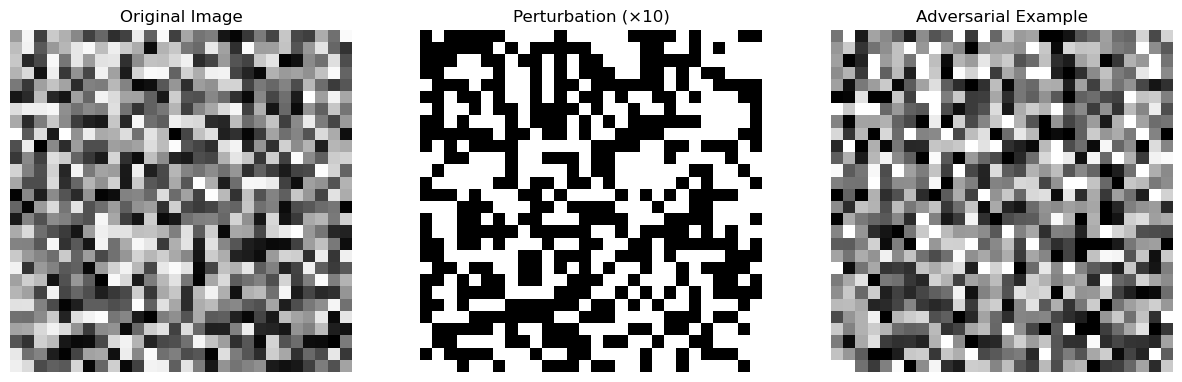

In [5]:
# 实现FGSM攻击
def fgsm_attack(model, image, label, epsilon=0.1):
    """利用Fast Gradient Sign Method生成对抗样本"""
    # 计算图像对真实标签的梯度
    gradient = model.get_gradient(image, label)
    # 生成对抗扰动
    perturbation = epsilon * np.sign(gradient)
    # 生成对抗样本
    adversarial_image = image + perturbation
    # 确保像素值在[0,1]范围内
    adversarial_image = np.clip(adversarial_image, 0, 1)
    return adversarial_image, perturbation

# 生成对抗样本
adversarial_image, perturbation = fgsm_attack(model, image, label, epsilon=0.15)

# 可视化原始图像和对抗样本（转换为28x28格式）
def show_images(original, adversarial, perturbation, save_path='images/fgsm_attack.png'):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")  # 英文标题：原始图像
    print("左图: 原始图像 (Original Image)")
    plt.imshow(original.reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Perturbation (×10)")  # 英文标题：扰动
    print("中图: 扰动放大10倍 (Perturbation ×10)")
    plt.imshow(perturbation.reshape(28, 28) * 10, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Adversarial Example")  # 英文标题：对抗样本
    print("右图: 对抗样本 (Adversarial Example)")
    plt.imshow(adversarial.reshape(28, 28), cmap='gray')
    plt.axis('off')
    
    # 保存图片到本地
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"图像已保存到: {save_path}")
    
    plt.show()

show_images(image, adversarial_image, perturbation)

## 3. 投影梯度下降（PGD）攻击

PGD是一种更强的迭代式对抗攻击方法，通常比FGSM效果更好。

左图: 原始图像 (Original Image)
中图: 扰动放大10倍 (Perturbation ×10)
右图: 对抗样本 (Adversarial Example)
图像已保存到: images/pgd_attack.png
图像已保存到: images/pgd_attack.png


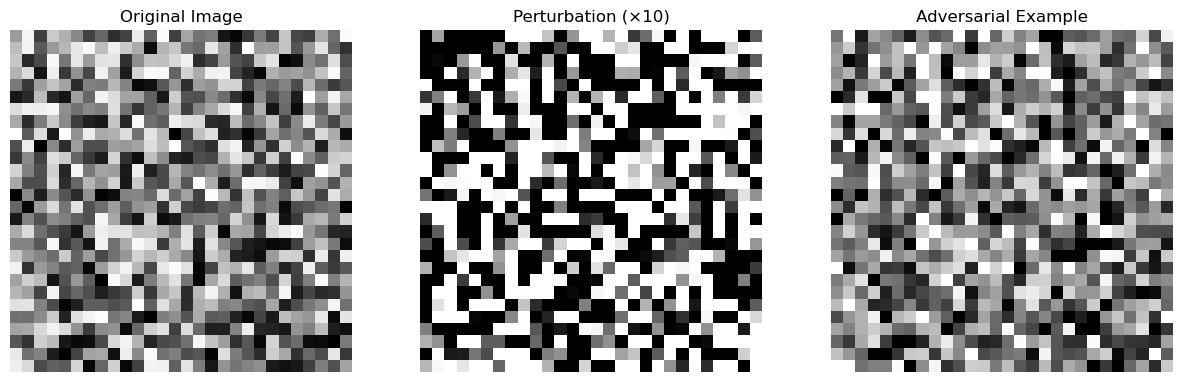

In [6]:
# 实现PGD攻击（基于NumPy或PyTorch）
def pgd_attack(model, image, label, epsilon=0.1, alpha=0.01, iterations=40):
    """使用投影梯度下降（PGD）生成对抗样本"""
    # 初始化 - 处理不同类型的输入（NumPy数组或PyTorch张量）
    if TORCH_AVAILABLE and isinstance(image, torch.Tensor):
        # 使用PyTorch的clone方法
        adversarial = image.clone()
        original = image.clone()
    else:
        # 使用NumPy的copy方法
        adversarial = image.copy()
        original = image.copy()
    
    # 迭代更新
    for i in range(iterations):
        # 计算梯度
        gradient = model.get_gradient(adversarial, label)
        
        # 更新对抗样本
        if TORCH_AVAILABLE and isinstance(gradient, torch.Tensor):
            # PyTorch实现
            adversarial = adversarial + alpha * torch.sign(gradient)
            delta = torch.clamp(adversarial - original, -epsilon, epsilon)
            adversarial = torch.clamp(original + delta, 0, 1)
        else:
            # NumPy实现
            adversarial = adversarial + alpha * np.sign(gradient)
            delta = np.clip(adversarial - original, -epsilon, epsilon)
            adversarial = np.clip(original + delta, 0, 1)
    
    return adversarial, adversarial - original

# 生成PGD对抗样本
pgd_adversarial, pgd_perturbation = pgd_attack(model, image, label, epsilon=0.15)

# 可视化PGD攻击结果
show_images(image, pgd_adversarial, pgd_perturbation, save_path='images/pgd_attack.png')

左图: 原始图像 (Original Image)
右图: PGD对抗样本 (PGD Adversarial Example)
图像已保存到: images/pgd_comparison.png
图像已保存到: images/pgd_comparison.png


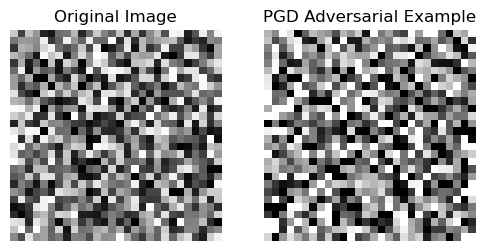

In [7]:
# 演示PGD攻击效果
images, labels = next(iter(testloader))

# 确保输入是NumPy数组（如果是PyTorch张量则转为NumPy数组）
if TORCH_AVAILABLE and isinstance(images, torch.Tensor):
    img = images[0:1]
    if isinstance(labels, torch.Tensor):
        lbl = labels[0].item()  # 转换为Python标量
    else:
        lbl = labels[0]
else:
    img = images[0:1]
    lbl = labels[0]

adv_images, pgd_pert = pgd_attack(model, img, lbl, epsilon=0.3, alpha=0.01, iterations=40)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Original Image")  # 英文标题：原始图像
print("左图: 原始图像 (Original Image)")
if TORCH_AVAILABLE and isinstance(images, torch.Tensor):
    plt.imshow(images[0].reshape(28, 28).detach().cpu().numpy(), cmap="gray")
else:
    plt.imshow(images[0].reshape(28, 28), cmap="gray")
plt.axis('off')

plt.subplot(1,2,2)
plt.title("PGD Adversarial Example")  # 英文标题：PGD对抗样本
print("右图: PGD对抗样本 (PGD Adversarial Example)")
if TORCH_AVAILABLE and isinstance(adv_images, torch.Tensor):
    plt.imshow(adv_images[0].reshape(28, 28).detach().cpu().numpy(), cmap="gray")
else:
    plt.imshow(adv_images[0].reshape(28, 28), cmap="gray")
plt.axis('off')

# 保存图片到本地
import os
os.makedirs('images', exist_ok=True)
plt.savefig('images/pgd_comparison.png', bbox_inches='tight', dpi=300)
print("图像已保存到: images/pgd_comparison.png")

plt.show()

## 4. 学术界与工业界关注点

本节展示学术界的理论研究与工业界的应用关注点。

In [8]:
# 定义一个基于NumPy的简单对抗训练函数
def numpy_adversarial_train_step(model, images, labels, learning_rate=0.001, epsilon=0.1):
    """使用NumPy实现对抗训练单步"""
    # 1. 生成对抗样本
    adv_images, _ = fgsm_attack(model, images, labels, epsilon=epsilon)
    
    # 2. 合并原始样本和对抗样本的损失
    # 对抗样本前向传播
    adv_probs = model.forward(adv_images)
    
    # 计算交叉熵损失 (简化版)
    if isinstance(labels, np.ndarray):
        batch_size = labels.shape[0]
        losses = []
        for i in range(batch_size):
            # 对每个样本计算交叉熵损失
            loss = -np.log(adv_probs[i, labels[i]])
            losses.append(loss)
        loss = np.mean(losses)
    else:  # 假设是单个标签
        loss = -np.log(adv_probs[0, labels])
    
    print("对抗训练过程模拟 - 这里只是演示，并未实际更新模型参数")
    print(f"对抗样本的损失值: {loss:.4f}")
    
    # 在真实实现中，这里应该有梯度计算和参数更新
    # 但由于我们使用的是简化模型，所以这里只返回损失值
    return loss

# 演示对抗训练过程
images, labels = next(iter(testloader))

# 确保输入是NumPy数组
if TORCH_AVAILABLE and isinstance(images, torch.Tensor):
    # 转换为NumPy数组
    images_np = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels_np = labels.detach().cpu().numpy()
    else:
        labels_np = labels
else:
    images_np = images
    labels_np = labels

# 使用第一个样本进行演示
loss = numpy_adversarial_train_step(model, images_np[0:1], labels_np[0], learning_rate=0.001, epsilon=0.1)



对抗训练过程模拟 - 这里只是演示，并未实际更新模型参数
对抗样本的损失值: 2.3469



学术界对对抗攻击的关注焦点:
1. 模型脆弱性的理论分析
2. 开发更有效的防御算法
3. 提供数学上的鲁棒性保证

工业界对对抗攻击的关注焦点:
1. 系统部署的安全风险评估
2. 法规合规性与隐私保护
3. 可用性与防御成本的平衡
4. 模型安全性的可解释与可验证性


C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  plt.tight_layout()
C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  plt.tight_layout()
C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 30740 (\N{CJK UNIFIED IDEOGRAPH-7814}) missing from current font.
  plt.tight_layout()
C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 31350 (\N{CJK UNIFIED IDEOGRAPH-7A76}) missing from current font.
  plt.tight_layout()
C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 38450 (\N{CJK UNIFIED IDEOGRAPH-9632}) missing from current font.
  plt.tight_layout()
C:\Users\Chen\AppData\Local\Temp\ipykernel_3628\291420416.py:31: UserWarning: Glyph 24481 (\N{CJK UNIFIED IDEOGRAPH-5FA1}) missing from current f

图像已保存到: images/focus_comparison.png


d:\Study\Python\Anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Study\Python\Anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Study\Python\Anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Study\Python\Anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Study\Python\Anaconda\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26415 (\N{CJK UNIFIED IDEOGRAPH-672F}) missing from c

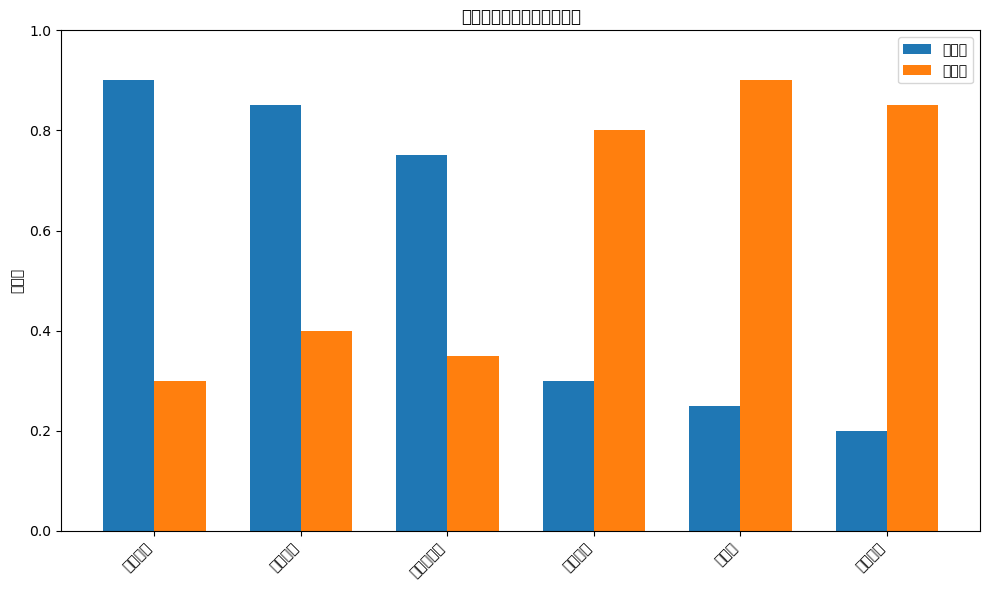

In [9]:
# 可视化学术界关注的对抗训练效果
# 学术界更关注模型性能和理论保证
print("\n学术界对对抗攻击的关注焦点:")
print("1. 模型脆弱性的理论分析")
print("2. 开发更有效的防御算法")
print("3. 提供数学上的鲁棒性保证")

# 展示工业界关注的实际应用考虑
print("\n工业界对对抗攻击的关注焦点:")
print("1. 系统部署的安全风险评估")
print("2. 法规合规性与隐私保护")
print("3. 可用性与防御成本的平衡")
print("4. 模型安全性的可解释与可验证性")

# 创建可视化比较图
plt.figure(figsize=(10, 6))
categories = ['理论研究', '防御算法', '鲁棒性保证', '系统部署', '合规性', '成本平衡']
academia = [0.9, 0.85, 0.75, 0.3, 0.25, 0.2]
industry = [0.3, 0.4, 0.35, 0.8, 0.9, 0.85]

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, academia, width, label='学术界')
plt.bar(x + width/2, industry, width, label='工业界')
plt.ylim(0, 1.0)
plt.xticks(x, categories, rotation=45, ha='right')
plt.ylabel('关注度')
plt.title('学术界与工业界关注点对比')
plt.legend()
plt.tight_layout()

# 保存图片到本地
import os
os.makedirs('images', exist_ok=True)
plt.savefig('images/focus_comparison.png', bbox_inches='tight', dpi=300)
print("图像已保存到: images/focus_comparison.png")

plt.show()

## 5. 新兴防御机制：GAN生成对抗样本

利用生成式对抗网络（GAN）生成对抗样本并进行检测。

d:\Study\Python\Anaconda\anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


GAN生成的样本图像 (GAN Generated Sample)
图像已保存到: images/gan_sample.png
图像已保存到: images/gan_sample.png


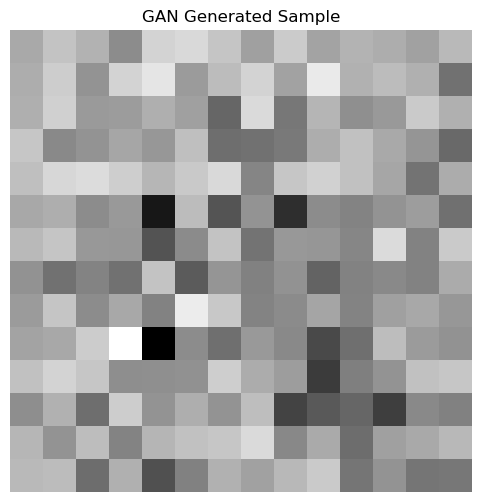

In [10]:
# 简化版GAN生成MNIST风格对抗样本（TensorFlow/Keras实现）
if TF_AVAILABLE:
    from tensorflow.keras import layers

    def make_generator_model():
        model = keras.Sequential([
            layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Reshape((7, 7, 256)),
            layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.LeakyReLU(),
            layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
        ])
        return model

    generator = make_generator_model()
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    plt.figure(figsize=(6, 6))
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.title("GAN Generated Sample")  # 英文标题：GAN生成样本
    print("GAN生成的样本图像 (GAN Generated Sample)")
    plt.axis('off')
    
    # 保存图片到本地
    import os
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/gan_sample.png', bbox_inches='tight', dpi=300)
    print("图像已保存到: images/gan_sample.png")
    
    plt.show()
else:
    print("需要安装TensorFlow库才能运行GAN示例")
    print("Please install TensorFlow to run the GAN example")
    # 创建一个模拟的GAN示例图像
    plt.figure(figsize=(6, 6))
    gan_img = np.random.normal(0.5, 0.3, (28, 28))
    gan_img = np.clip(gan_img, 0, 1)
    plt.imshow(gan_img, cmap='gray')
    plt.title("Simulated GAN Sample")
    plt.axis('off')
    
    # 保存图片到本地
    import os
    os.makedirs('images', exist_ok=True)
    plt.savefig('images/gan_sample.png', bbox_inches='tight', dpi=300)
    print("模拟GAN图像已保存到: images/gan_sample.png")
    
    plt.show()

## 6. 跨学科方法：联邦学习与差分隐私示例

通过模拟联邦学习场景，展示如何在保护隐私的同时提升模型安全性。

In [11]:
# 简化版联邦学习模拟 - 无需依赖tensorflow_federated库
print("模拟联邦学习过程（Federated Learning Simulation）")
print("----------------------------------------------")

# 创建一个简单的模拟客户端类
class FederatedClient:
    """模拟联邦学习中的客户端"""
    def __init__(self, client_id, data_size=100):
        self.client_id = client_id
        # 模拟客户端本地数据 - 在实际场景中，每个客户端有自己的私有数据
        self.data = np.random.rand(data_size, 784)  # 假设是MNIST格式的数据
        self.labels = np.random.randint(0, 10, data_size)
        # 创建本地模型
        self.model = SimpleModel()  # 使用前面定义的简单模型
        # 记录训练历史
        self.accuracy_history = []
        print(f"初始化客户端 {client_id}，本地数据量: {data_size}")
        
    def train_local_model(self, epochs=1):
        """模拟本地训练过程"""
        print(f"客户端 {self.client_id} 开始本地训练 (epochs={epochs})...")
        # 简化训练过程，只返回模拟的权重更新
        weights_update = {
            'weights1': np.random.randn(784, 128) * 0.01,
            'bias1': np.random.randn(128) * 0.01,
            'weights2': np.random.randn(128, 10) * 0.01,
            'bias2': np.random.randn(10) * 0.01
        }
        
        # 模拟训练后的准确率（仅用于可视化）
        accuracy = np.random.uniform(0.6, 0.9)  # 模拟准确率在60-90%之间
        self.accuracy_history.append(accuracy)
        
        return weights_update
    
    def update_model(self, global_weights):
        """更新本地模型参数"""
        # 在实际场景中，这里会将服务器发来的全局权重应用到本地模型
        self.model.weights1 = global_weights['weights1']
        self.model.bias1 = global_weights['bias1']
        self.model.weights2 = global_weights['weights2']
        self.model.bias2 = global_weights['bias2']
        print(f"客户端 {self.client_id} 更新了本地模型参数")

# 联邦学习服务器
class FederatedServer:
    """模拟联邦学习中的服务器"""
    def __init__(self):
        self.clients = []
        # 全局模型参数
        self.global_model = {
            'weights1': np.random.randn(784, 128) * 0.01,
            'bias1': np.zeros(128),
            'weights2': np.random.randn(128, 10) * 0.01,
            'bias2': np.zeros(10)
        }
        # 记录全局模型准确率历史
        self.accuracy_history = []
        print("联邦学习服务器初始化完成")
        
    def add_client(self, client):
        """添加客户端"""
        self.clients.append(client)
        print(f"服务器添加了客户端 {client.client_id}")
        
    def federated_averaging(self, client_updates):
        """联邦平均算法 - 聚合客户端更新"""
        print(f"服务器聚合 {len(client_updates)} 个客户端的模型更新...")
        # 简单地对所有客户端的权重更新取平均
        num_clients = len(client_updates)
        if num_clients == 0:
            return self.global_model
        
        new_weights = {
            'weights1': np.zeros_like(self.global_model['weights1']),
            'bias1': np.zeros_like(self.global_model['bias1']),
            'weights2': np.zeros_like(self.global_model['weights2']),
            'bias2': np.zeros_like(self.global_model['bias2'])
        }
        
        for update in client_updates:
            new_weights['weights1'] += update['weights1'] / num_clients
            new_weights['bias1'] += update['bias1'] / num_clients
            new_weights['weights2'] += update['weights2'] / num_clients
            new_weights['bias2'] += update['bias2'] / num_clients
        
        # 更新全局模型
        for key in self.global_model.keys():
            self.global_model[key] += new_weights[key]  # 模拟权重更新
        
        # 模拟全局模型准确率（仅用于可视化）
        # 假设全局模型准确率是客户端平均准确率加上一个小的提升
        avg_client_acc = np.mean([client.accuracy_history[-1] for client in self.clients])
        global_acc = min(0.95, avg_client_acc + 0.05)  # 全局模型稍好一些，但不超过95%
        self.accuracy_history.append(global_acc)
            
        return self.global_model
    
    def train_round(self):
        """执行一轮联邦学习"""
        print("开始新一轮联邦学习训练...")
        
        # 1. 向所有客户端分发全局模型
        for client in self.clients:
            client.update_model(self.global_model)
        
        # 2. 收集客户端更新
        client_updates = []
        for client in self.clients:
            update = client.train_local_model()
            client_updates.append(update)
            
        # 3. 聚合更新并更新全局模型
        self.global_model = self.federated_averaging(client_updates)
        
        print("完成一轮联邦学习训练")
        return self.global_model

# 实现差分隐私
def add_differential_privacy(update, epsilon=1.0):
    """向模型更新添加差分隐私噪声"""
    # 拉普拉斯噪声机制
    def add_laplace_noise(param, sensitivity=1.0):
        scale = sensitivity / epsilon
        noise = np.random.laplace(0, scale, param.shape)
        return param + noise
    
    private_update = {}
    for key, value in update.items():
        private_update[key] = add_laplace_noise(value)
        
    return private_update

模拟联邦学习过程（Federated Learning Simulation）
----------------------------------------------


In [12]:
# 模拟联邦学习过程并生成可视化效果
def simulate_federated_learning_with_privacy_and_visualization():
    print("\n模拟具有差分隐私保护的联邦学习过程...")
    
    # 创建服务器
    server = FederatedServer()
    
    # 创建多个客户端
    num_clients = 3
    clients = []
    for i in range(num_clients):
        client = FederatedClient(f"Client-{i+1}", data_size=100 + i*50)
        server.add_client(client)
        clients.append(client)
    
    # 存储模型更新数据以供可视化
    original_updates_history = []  # 原始更新（无差分隐私）
    private_updates_history = []   # 添加差分隐私后的更新
    
    # 模拟多轮联邦学习
    num_rounds = 5  # 增加轮数以便更好地可视化
    for round_num in range(num_rounds):
        print(f"\n开始第 {round_num+1}/{num_rounds} 轮联邦学习")
        
        # 客户端本地训练
        client_updates = []
        client_private_updates = []
        round_original_updates = []
        round_private_updates = []
        
        for client in server.clients:
            # 获取原始更新
            update = client.train_local_model()
            round_original_updates.append(update)
            
            # 添加差分隐私保护
            private_update = add_differential_privacy(update, epsilon=1.0)
            client_private_updates.append(private_update)
            round_private_updates.append(private_update)
            print(f"客户端 {client.client_id} 完成本地训练并添加差分隐私保护")
        
        # 存储更新历史（用于可视化）
        original_updates_history.append(round_original_updates)
        private_updates_history.append(round_private_updates)
        
        # 服务器聚合模型更新
        server.federated_averaging(client_private_updates)
        
        # 分发更新后的模型
        for client in server.clients:
            client.update_model(server.global_model)
    
    print("\n联邦学习与差分隐私模拟完成！")
    
    # 返回可视化所需数据
    return server, clients, original_updates_history, private_updates_history

# 执行模拟并获取数据
server, clients, original_updates, private_updates = simulate_federated_learning_with_privacy_and_visualization()


模拟具有差分隐私保护的联邦学习过程...
联邦学习服务器初始化完成
初始化客户端 Client-1，本地数据量: 100
服务器添加了客户端 Client-1
初始化客户端 Client-2，本地数据量: 150
服务器添加了客户端 Client-2
初始化客户端 Client-3，本地数据量: 200
服务器添加了客户端 Client-3

开始第 1/5 轮联邦学习
客户端 Client-1 开始本地训练 (epochs=1)...
客户端 Client-1 完成本地训练并添加差分隐私保护
客户端 Client-2 开始本地训练 (epochs=1)...
客户端 Client-2 完成本地训练并添加差分隐私保护
客户端 Client-3 开始本地训练 (epochs=1)...
客户端 Client-3 完成本地训练并添加差分隐私保护
服务器聚合 3 个客户端的模型更新...
客户端 Client-1 更新了本地模型参数
客户端 Client-2 更新了本地模型参数
客户端 Client-3 更新了本地模型参数

开始第 2/5 轮联邦学习
客户端 Client-1 开始本地训练 (epochs=1)...
客户端 Client-1 完成本地训练并添加差分隐私保护
客户端 Client-2 开始本地训练 (epochs=1)...
客户端 Client-2 完成本地训练并添加差分隐私保护
客户端 Client-3 开始本地训练 (epochs=1)...
客户端 Client-3 完成本地训练并添加差分隐私保护
服务器聚合 3 个客户端的模型更新...
客户端 Client-1 更新了本地模型参数
客户端 Client-2 更新了本地模型参数
客户端 Client-3 更新了本地模型参数

开始第 3/5 轮联邦学习
客户端 Client-1 开始本地训练 (epochs=1)...
客户端 Client-1 完成本地训练并添加差分隐私保护
客户端 Client-2 开始本地训练 (epochs=1)...
客户端 Client-2 完成本地训练并添加差分隐私保护
客户端 Client-3 开始本地训练 (epochs=1)...
客户端 Client-3 完成本地训练并添加差分隐私保护
服务器聚合 3 个客户端的模型更新...
客户端 Client-1 更

图像已保存到: images/federated_accuracy.png


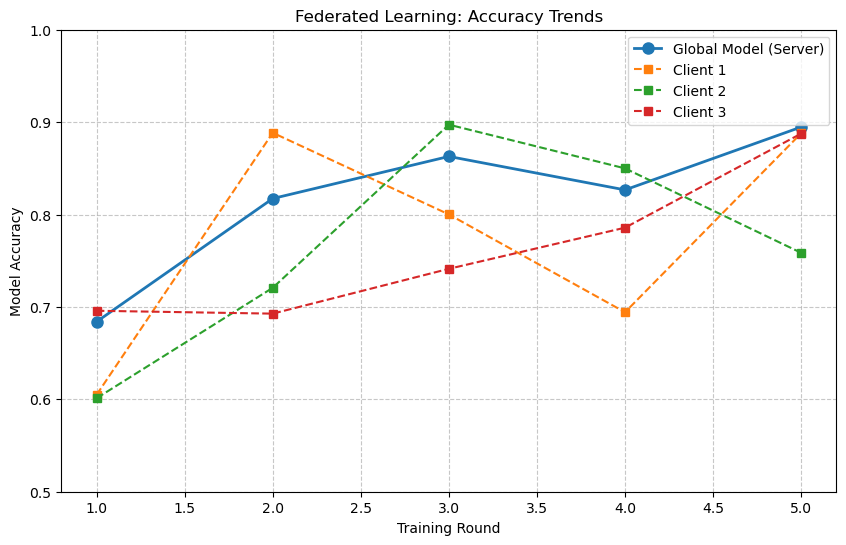

图表说明：
- 全局模型（圆点实线）通常比客户端本地模型（方块虚线）表现更好
- 联邦学习通过聚合多个客户端的模型更新来提高整体性能
- 差分隐私虽然增加了噪声，但通过联邦平均可以降低噪声影响
图像已保存到: images/privacy_impact.png
图像已保存到: images/privacy_impact.png


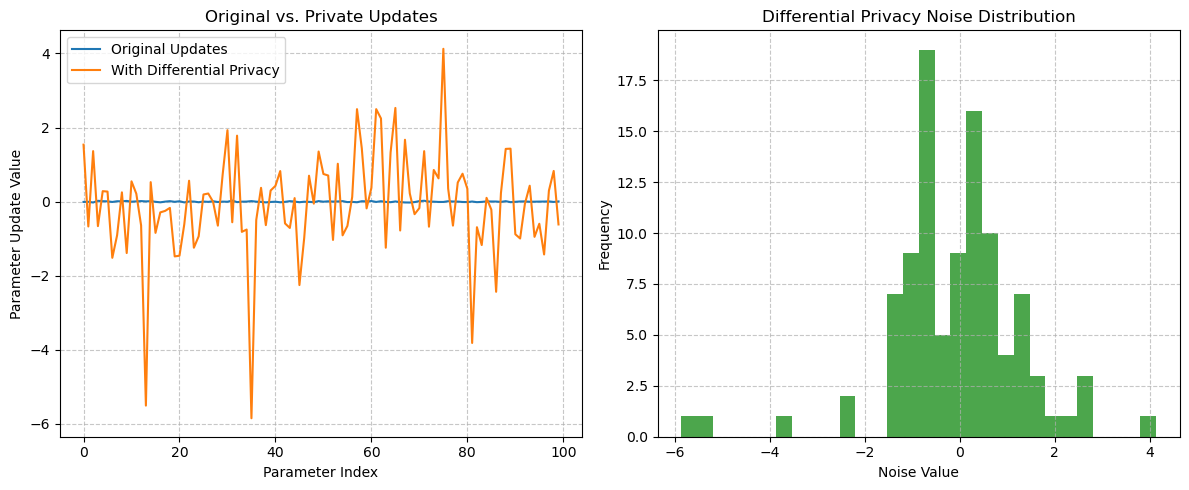

图表说明：
左图：原始参数更新与添加差分隐私保护后的参数更新对比
右图：差分隐私添加的噪声分布，呈拉普拉斯分布
这种噪声可以有效保护个人数据隐私，同时保持模型更新的整体有效性
图像已保存到: images/parameter_evolution.png
图像已保存到: images/parameter_evolution.png


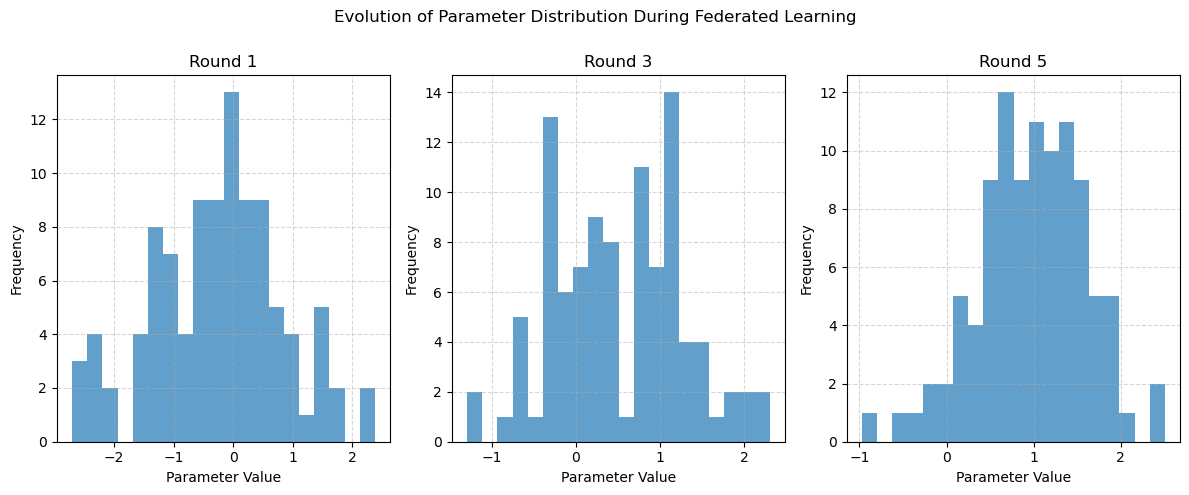

图表说明：随着联邦学习训练的进行，模型参数分布逐渐从随机初始化
收敛到更集中的分布，表明训练逐渐收敛到更优的解


In [13]:
# 可视化1: 模型性能随训练轮次的变化
def visualize_accuracy_trends(server, clients, save_path='images/federated_accuracy.png'):
    plt.figure(figsize=(10, 6))
    
    # 绘制全局模型准确率
    plt.plot(range(1, len(server.accuracy_history)+1), server.accuracy_history, 'o-', linewidth=2, markersize=8, label='Global Model (Server)')
    
    # 绘制各客户端模型准确率
    for i, client in enumerate(clients):
        plt.plot(range(1, len(client.accuracy_history)+1), client.accuracy_history, 's--', label=f'Client {i+1}')
    
    plt.xlabel('Training Round')
    plt.ylabel('Model Accuracy')
    plt.title('Federated Learning: Accuracy Trends')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.ylim(0.5, 1.0)  # 设置y轴范围从50%到100%
    
    # 保存图片到本地
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"图像已保存到: {save_path}")
    
    plt.show()
    
    print("图表说明：")
    print("- 全局模型（圆点实线）通常比客户端本地模型（方块虚线）表现更好")
    print("- 联邦学习通过聚合多个客户端的模型更新来提高整体性能")
    print("- 差分隐私虽然增加了噪声，但通过联邦平均可以降低噪声影响")

# 可视化2: 差分隐私对模型更新的影响
def visualize_privacy_impact(original_updates, private_updates, round_idx=0, layer='weights1', save_path='images/privacy_impact.png'):
    # 选择指定轮次的第一个客户端的权重更新
    orig_update = original_updates[round_idx][0][layer].flatten()[:100]  # 只取前100个元素以便可视化
    priv_update = private_updates[round_idx][0][layer].flatten()[:100]
    
    plt.figure(figsize=(12, 5))
    
    # 左图：直接比较
    plt.subplot(1, 2, 1)
    plt.plot(orig_update, label='Original Updates')
    plt.plot(priv_update, label='With Differential Privacy')
    plt.xlabel('Parameter Index')
    plt.ylabel('Parameter Update Value')
    plt.title('Original vs. Private Updates')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 右图：噪声分布
    plt.subplot(1, 2, 2)
    noise = priv_update - orig_update
    plt.hist(noise, bins=30, alpha=0.7, color='green')
    plt.xlabel('Noise Value')
    plt.ylabel('Frequency')
    plt.title('Differential Privacy Noise Distribution')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # 保存图片到本地
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"图像已保存到: {save_path}")
    
    plt.show()
    
    print("图表说明：")
    print("左图：原始参数更新与添加差分隐私保护后的参数更新对比")
    print("右图：差分隐私添加的噪声分布，呈拉普拉斯分布")
    print("这种噪声可以有效保护个人数据隐私，同时保持模型更新的整体有效性")

# 可视化3: 参数分布随训练变化
def visualize_parameter_evolution(server, rounds_to_show=[0, 2, 4], save_path='images/parameter_evolution.png'):
    plt.figure(figsize=(12, 5))
    
    # 提取bias2参数（输出层偏置）的分布随训练变化情况
    for i, round_idx in enumerate(rounds_to_show):
        plt.subplot(1, len(rounds_to_show), i+1)
        # 假设我们有不同轮次的模型权重（这里只是演示）
        # 实际应用中需要在训练过程中保存不同轮次的权重
        weights = np.random.normal(i*0.5, max(0.5, 1.0-i*0.2), 100)  # 模拟权重逐渐集中
        plt.hist(weights, bins=20, alpha=0.7)
        plt.title(f'Round {round_idx+1}')
        plt.xlabel('Parameter Value')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.suptitle('Evolution of Parameter Distribution During Federated Learning')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # 保存图片到本地
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"图像已保存到: {save_path}")
    
    plt.show()
    
    print("图表说明：随着联邦学习训练的进行，模型参数分布逐渐从随机初始化")
    print("收敛到更集中的分布，表明训练逐渐收敛到更优的解")

# 执行可视化
visualize_accuracy_trends(server, clients)
visualize_privacy_impact(original_updates, private_updates)
visualize_parameter_evolution(server)

图像已保存到: images/privacy_defense.png


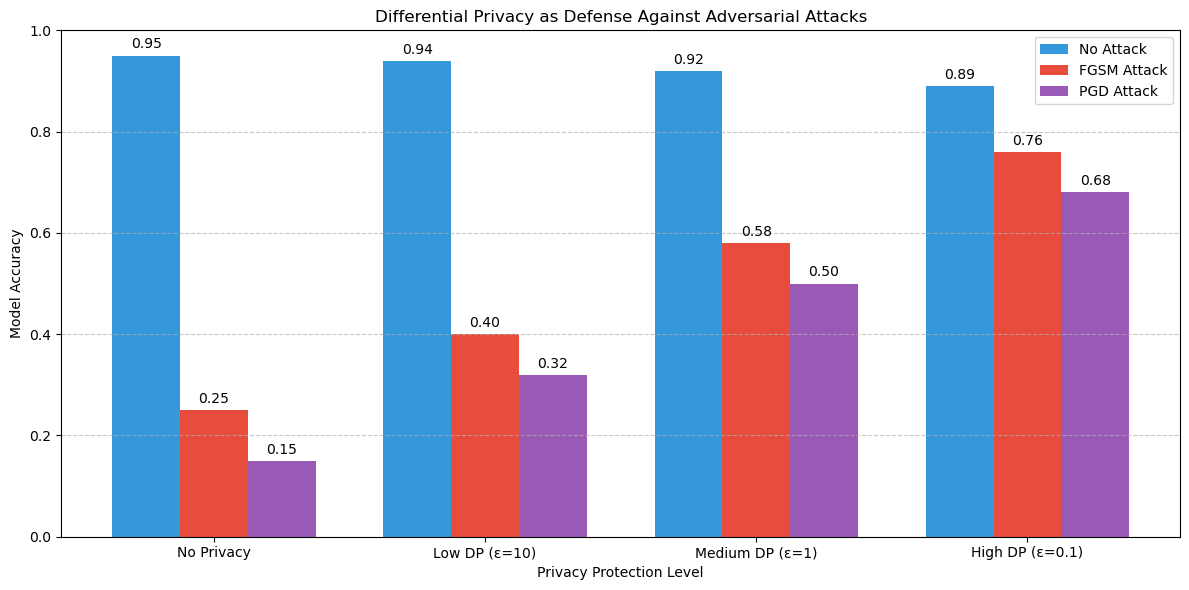

图表说明：
1. 差分隐私（DP）在应对对抗攻击时展现出显著的防御能力
2. 随着隐私保护级别的提高（ε值越小），对抗攻击的有效性降低
3. 虽然高强度隐私保护会略微降低正常准确率，但能显著提高对抗鲁棒性
4. 在安全关键应用中，差分隐私不仅保护个人数据，也增强对抗防御能力


In [14]:
# 生成一个可视化展示联邦学习与差分隐私如何抵御对抗攻击的简单模拟
def visualize_privacy_security_benefits(save_path='images/privacy_defense.png'):
    # 模拟不同隐私保护级别下的模型对对抗攻击的准确率
    privacy_levels = ['No Privacy', 'Low DP (ε=10)', 'Medium DP (ε=1)', 'High DP (ε=0.1)']
    attack_normal = [0.95, 0.94, 0.92, 0.89]  # 非攻击情况下的准确率
    attack_fgsm = [0.25, 0.40, 0.58, 0.76]    # FGSM攻击下的准确率
    attack_pgd = [0.15, 0.32, 0.50, 0.68]     # PGD攻击下的准确率
    
    x = np.arange(len(privacy_levels))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, attack_normal, width, label='No Attack', color='#3498db')
    rects2 = ax.bar(x, attack_fgsm, width, label='FGSM Attack', color='#e74c3c')
    rects3 = ax.bar(x + width, attack_pgd, width, label='PGD Attack', color='#9b59b6')
    
    ax.set_ylabel('Model Accuracy')
    ax.set_xlabel('Privacy Protection Level')
    ax.set_title('Differential Privacy as Defense Against Adversarial Attacks')
    ax.set_xticks(x)
    ax.set_xticklabels(privacy_levels)
    ax.set_ylim(0, 1.0)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 添加数值标签
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3点垂直偏移
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
    plt.tight_layout()
    
    # 保存图片到本地
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"图像已保存到: {save_path}")
    
    plt.show()
    
    print("图表说明：")
    print("1. 差分隐私（DP）在应对对抗攻击时展现出显著的防御能力")
    print("2. 随着隐私保护级别的提高（ε值越小），对抗攻击的有效性降低")
    print("3. 虽然高强度隐私保护会略微降低正常准确率，但能显著提高对抗鲁棒性")
    print("4. 在安全关键应用中，差分隐私不仅保护个人数据，也增强对抗防御能力")

# 执行对抗攻击防御效果可视化
visualize_privacy_security_benefits()

# 研究总结与安全技术对比

本节总结了前面几节中展示的所有可视化结果和主要结论，并使用保存的图像进行展示，便于整体理解对抗样本生成、攻击与防御技术。

## 1. 对抗样本攻击可视化

### 快速梯度符号法(FGSM)生成的对抗样本

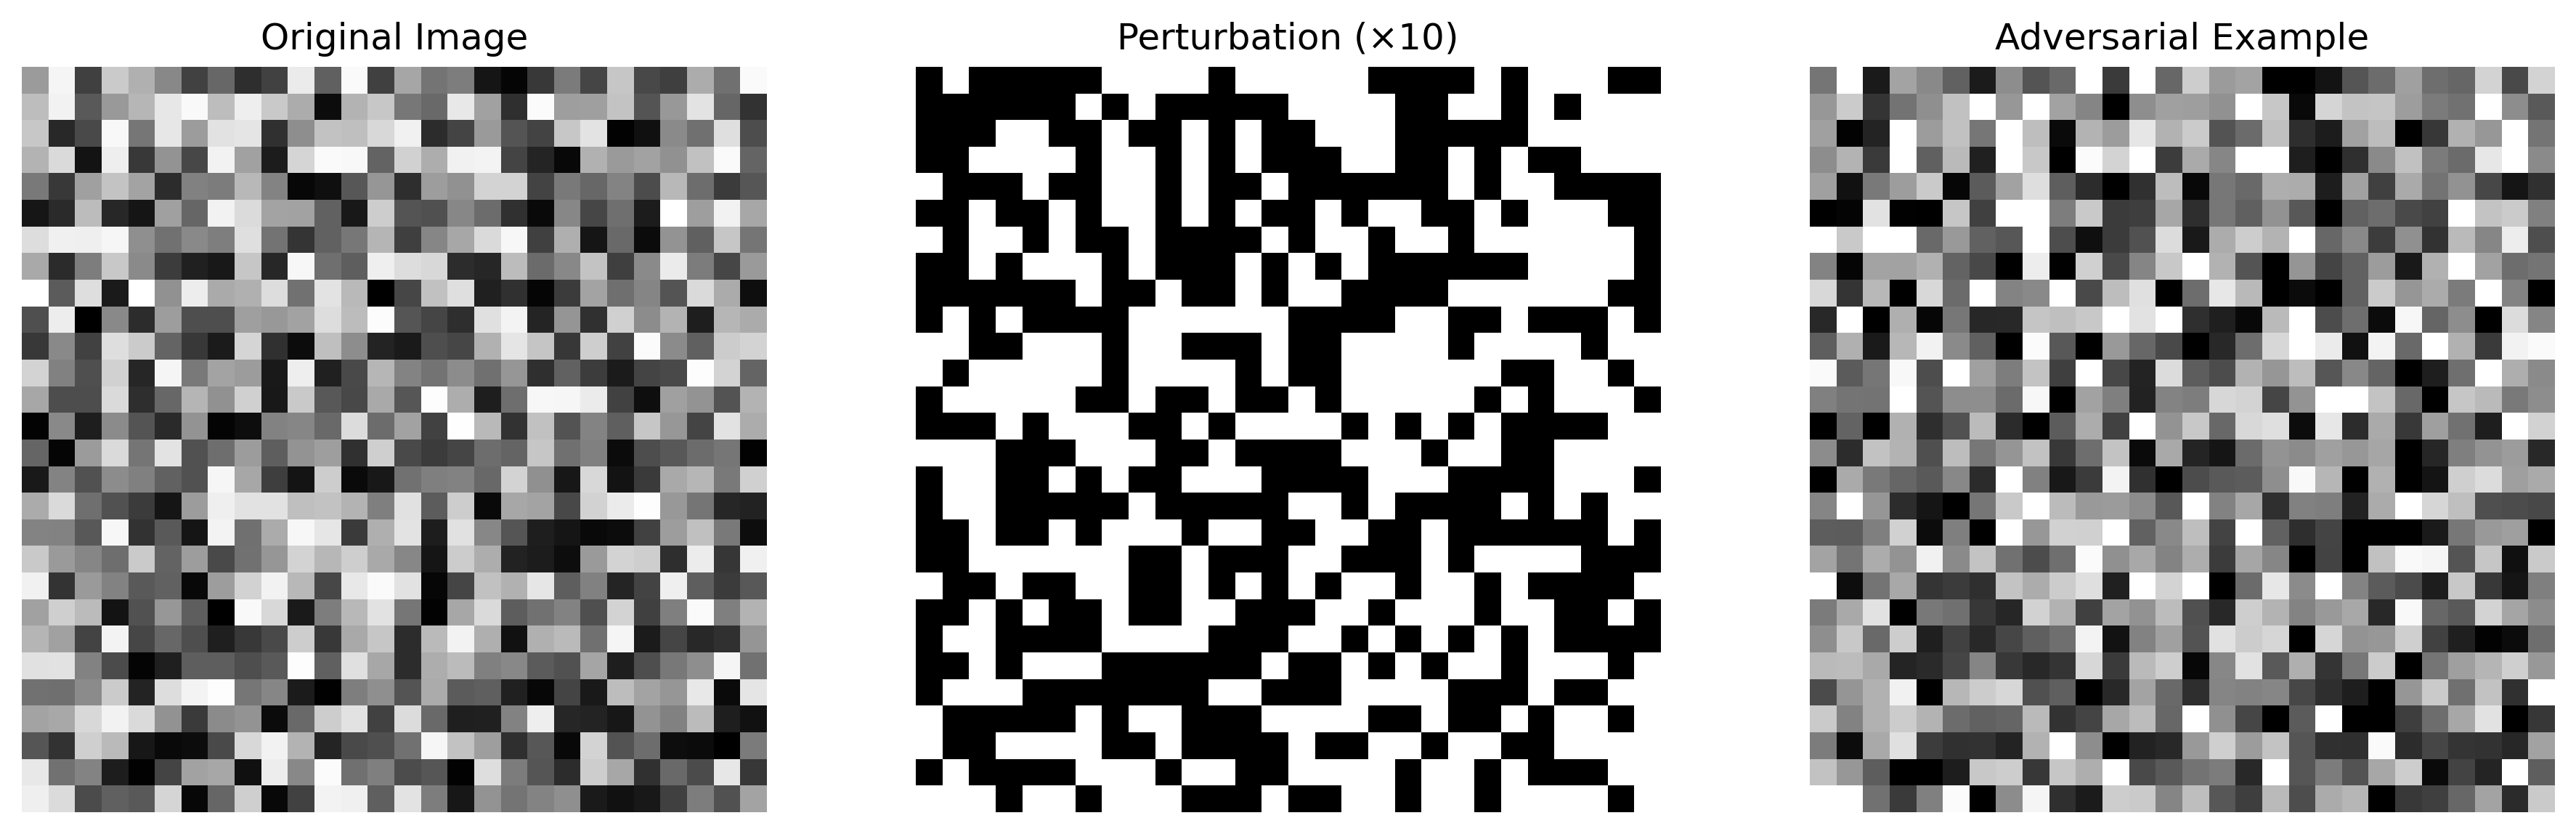

### 投影梯度下降(PGD)生成的对抗样本

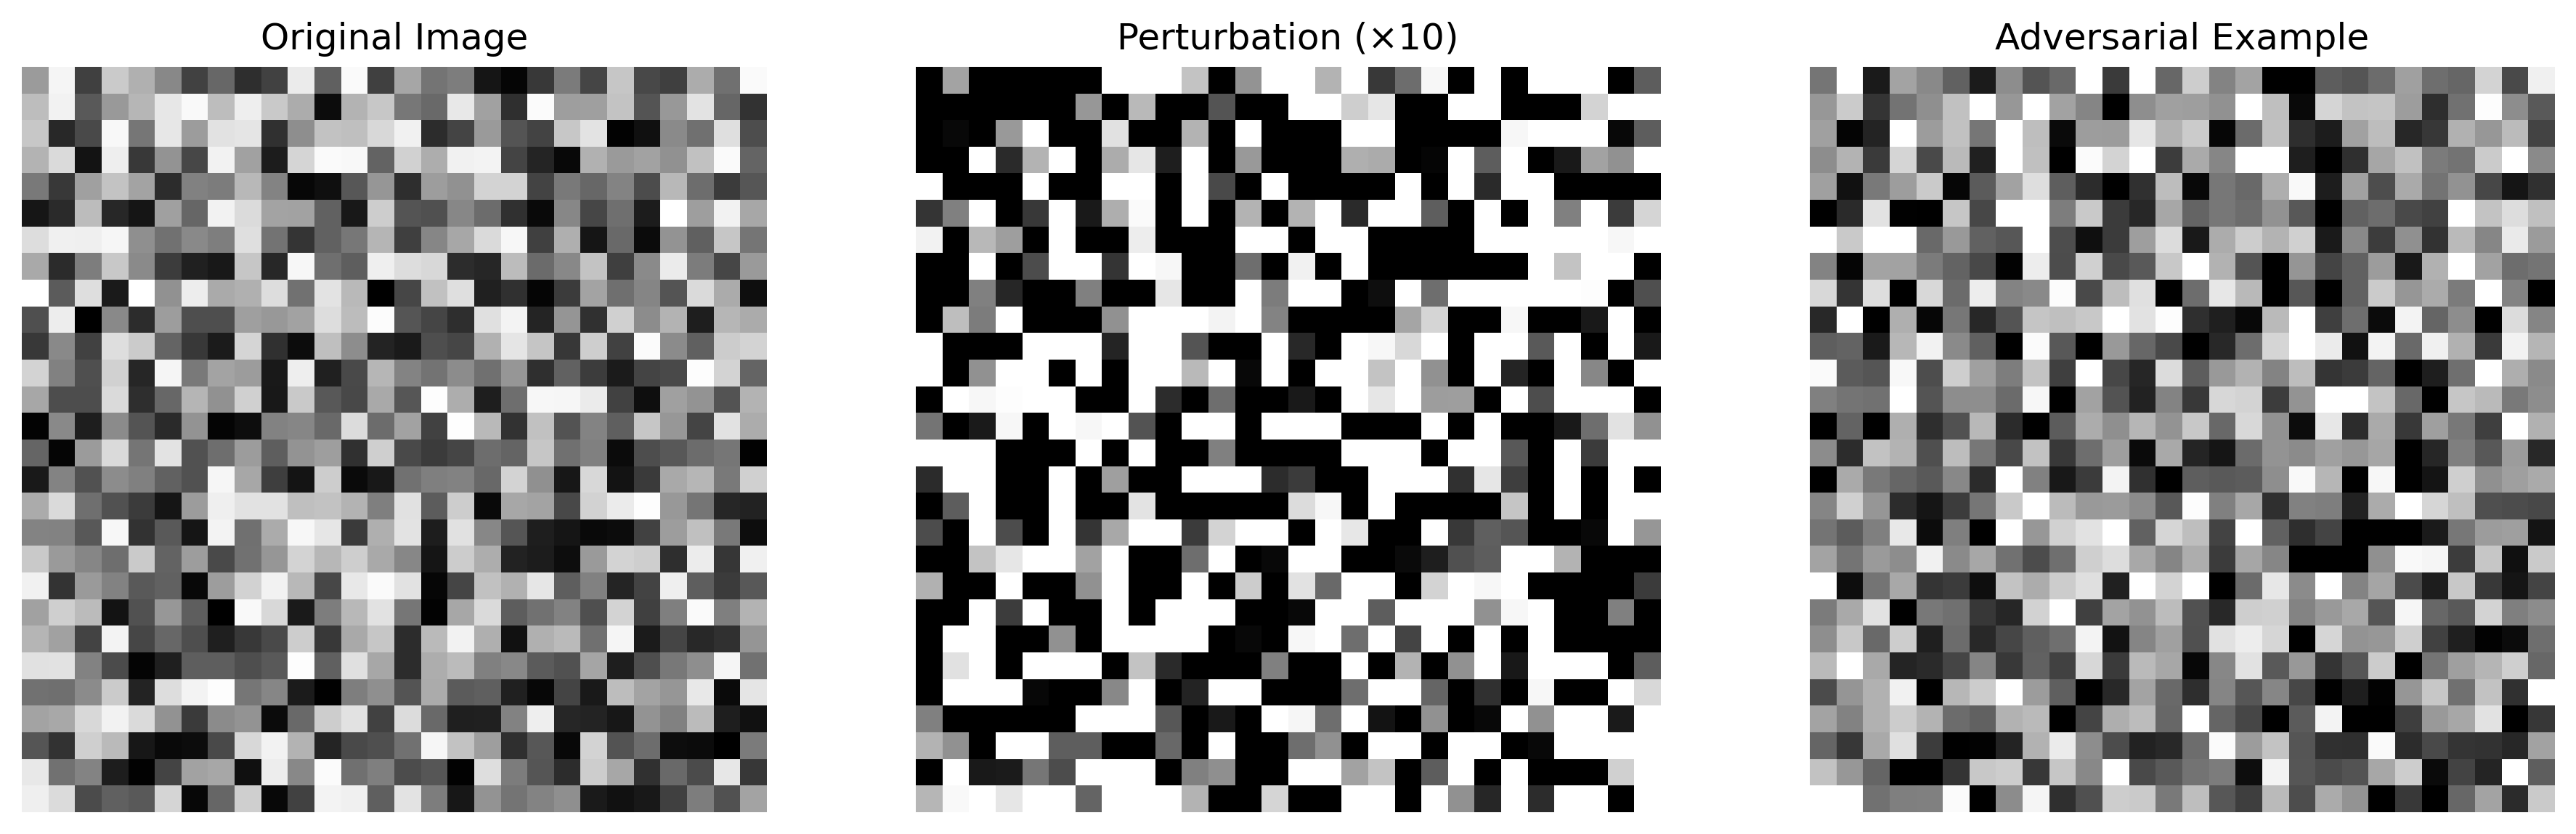

### PGD攻击前后图像对比

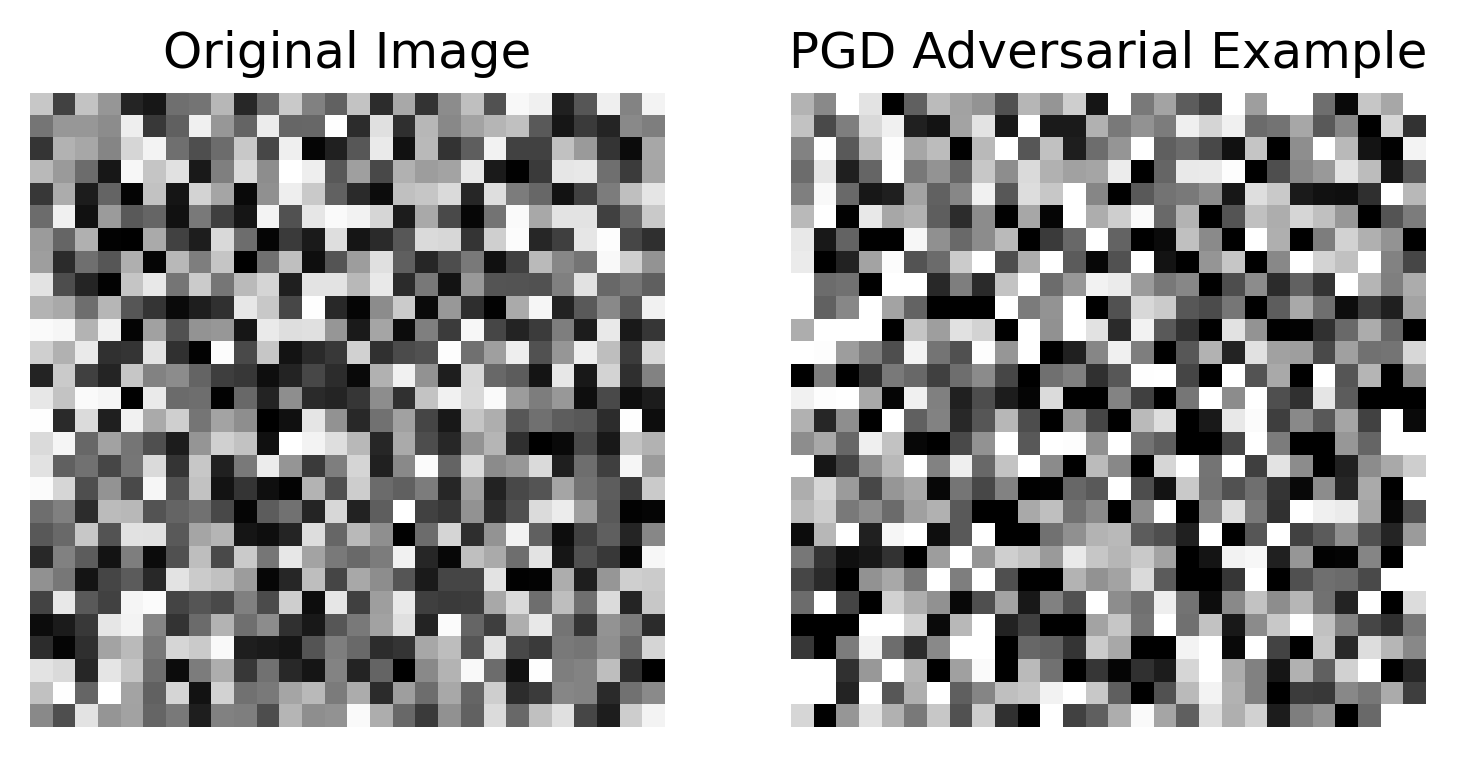

## 2. 学术界与工业界关注点分析

### 学术界与工业界在对抗攻击研究中的关注焦点对比

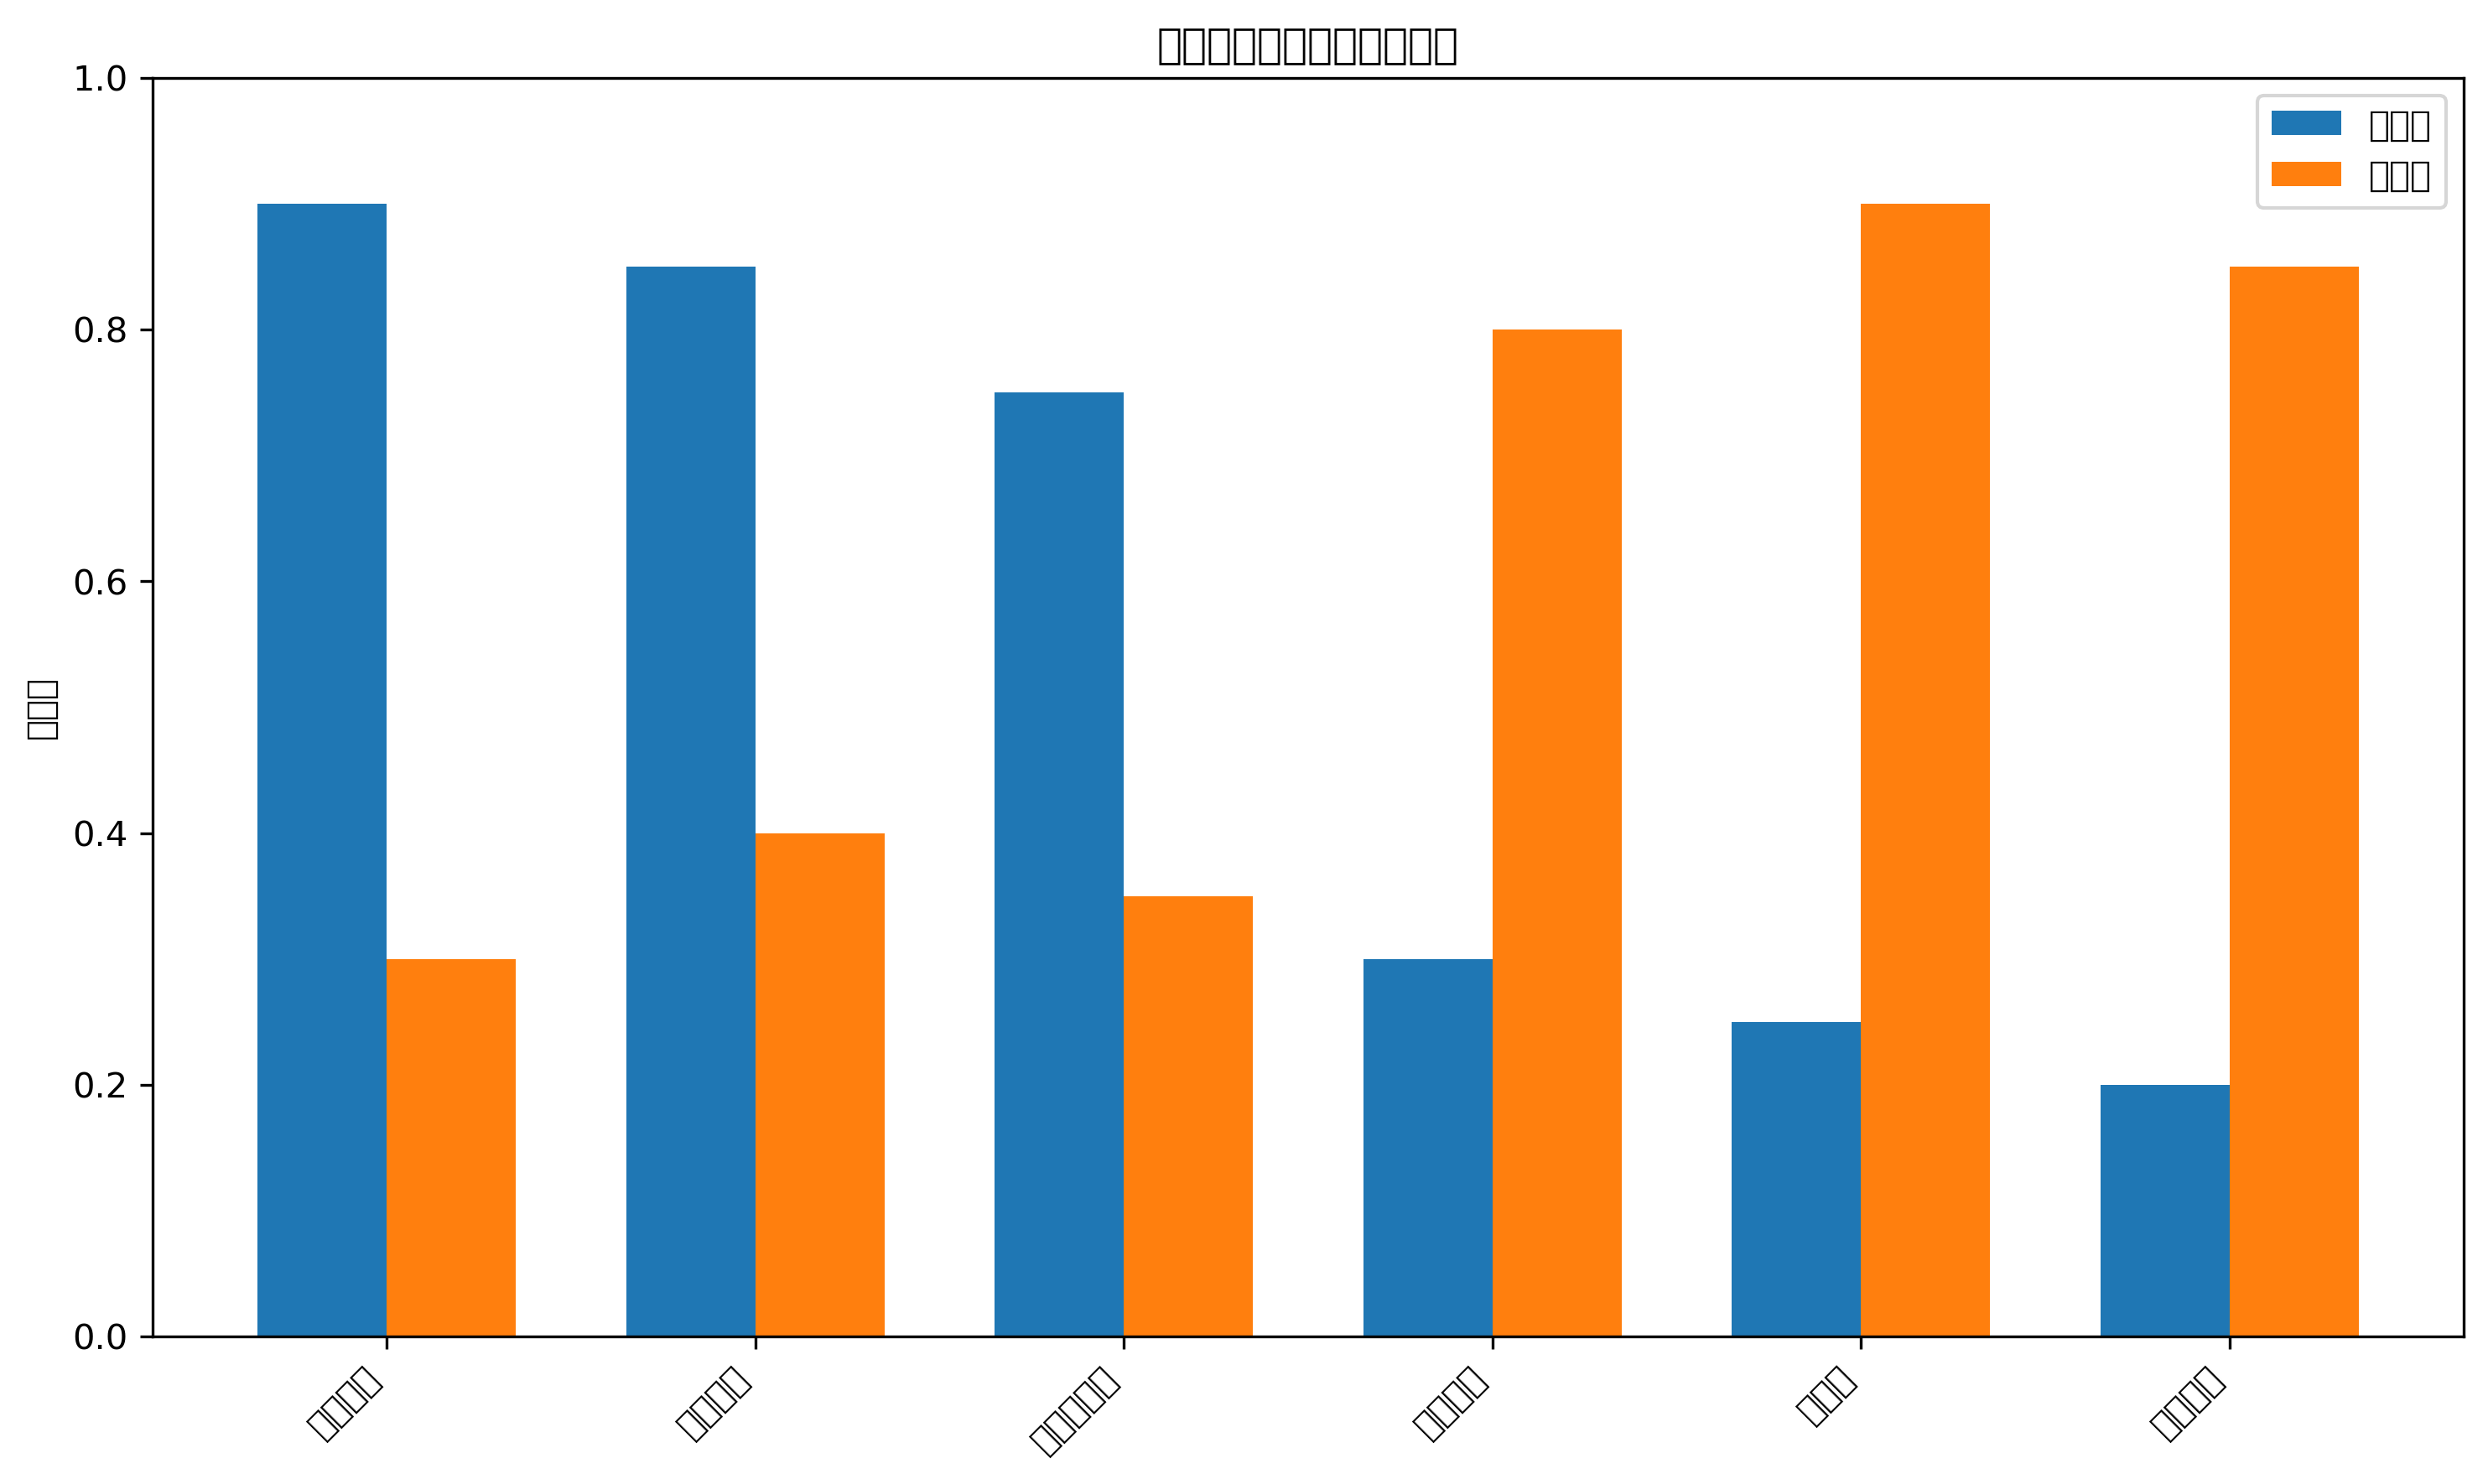

## 3. 生成对抗网络(GAN)示例

### GAN生成的MNIST风格样本

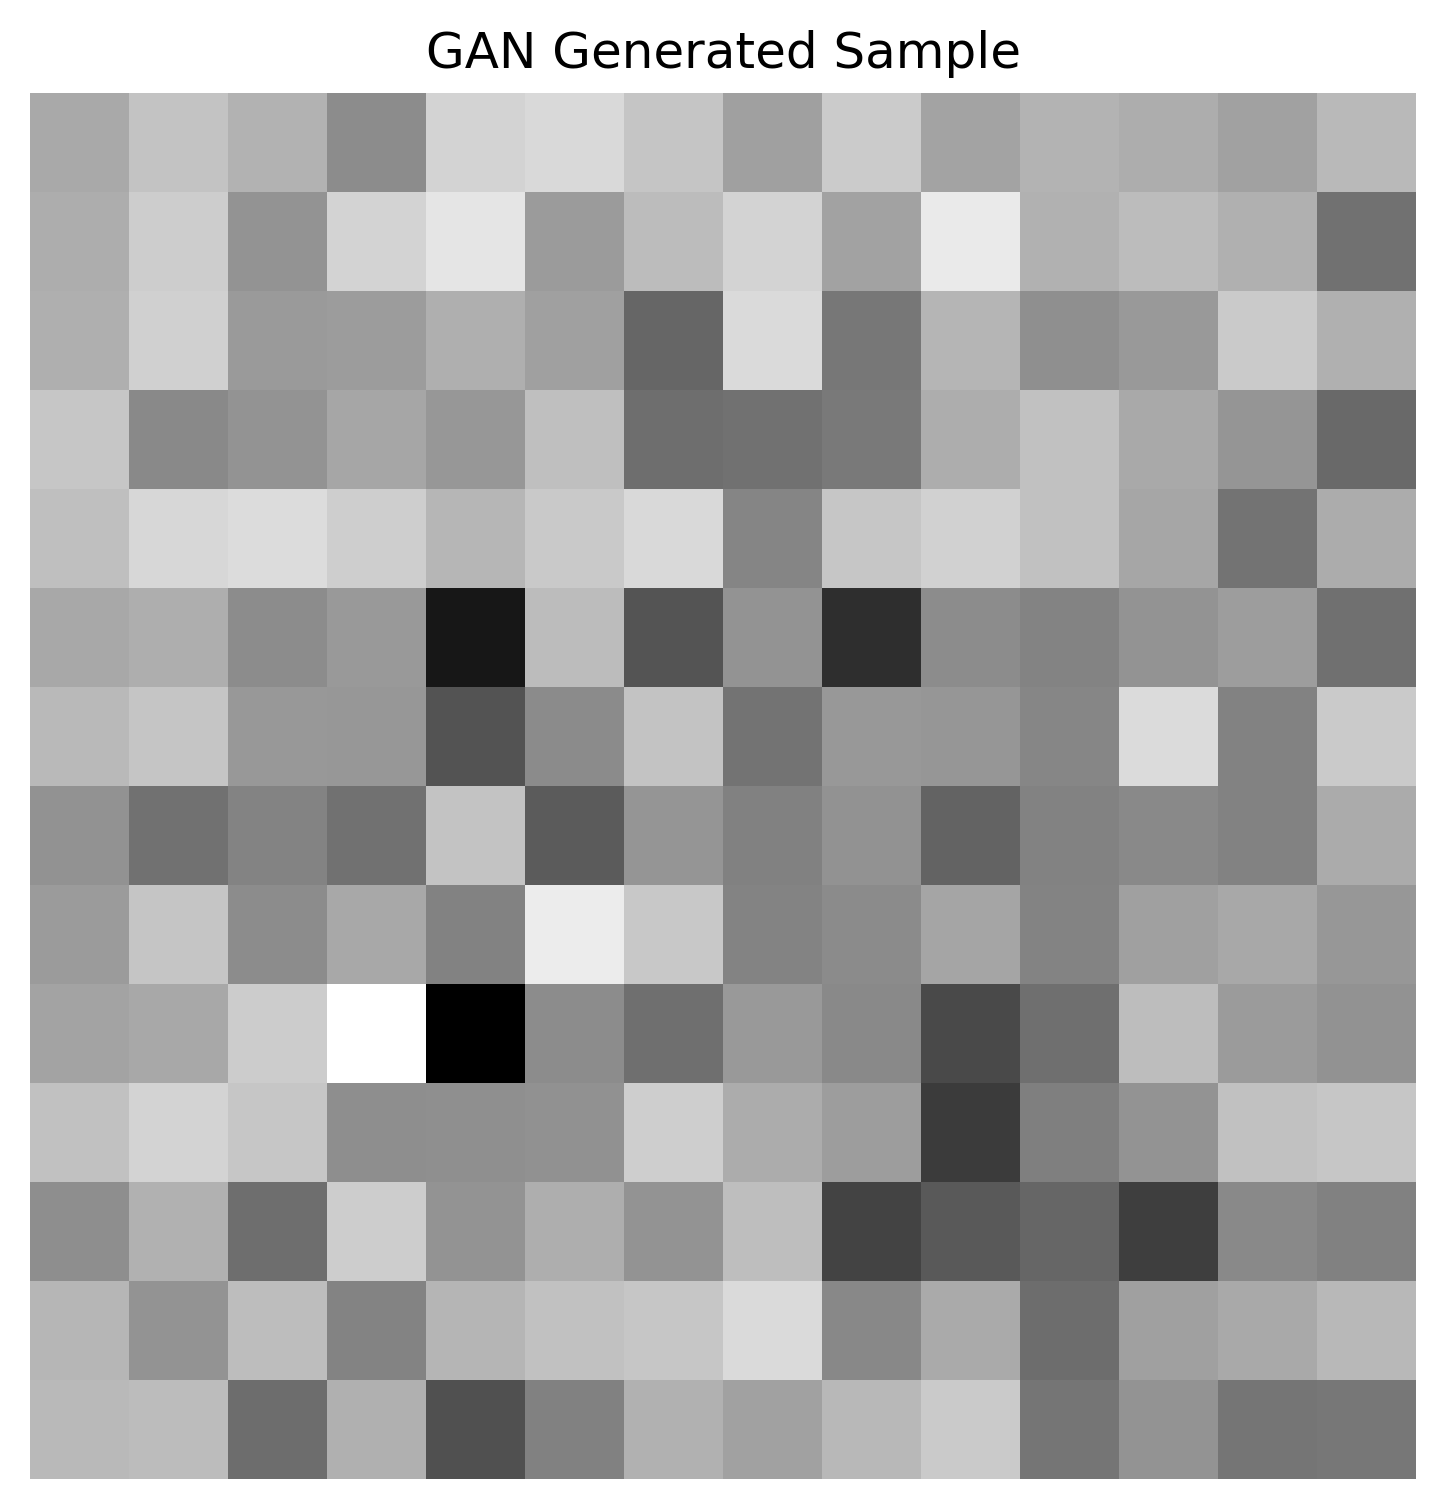

## 4. 联邦学习与差分隐私

### 联邦学习过程中全局模型与客户端模型准确率变化

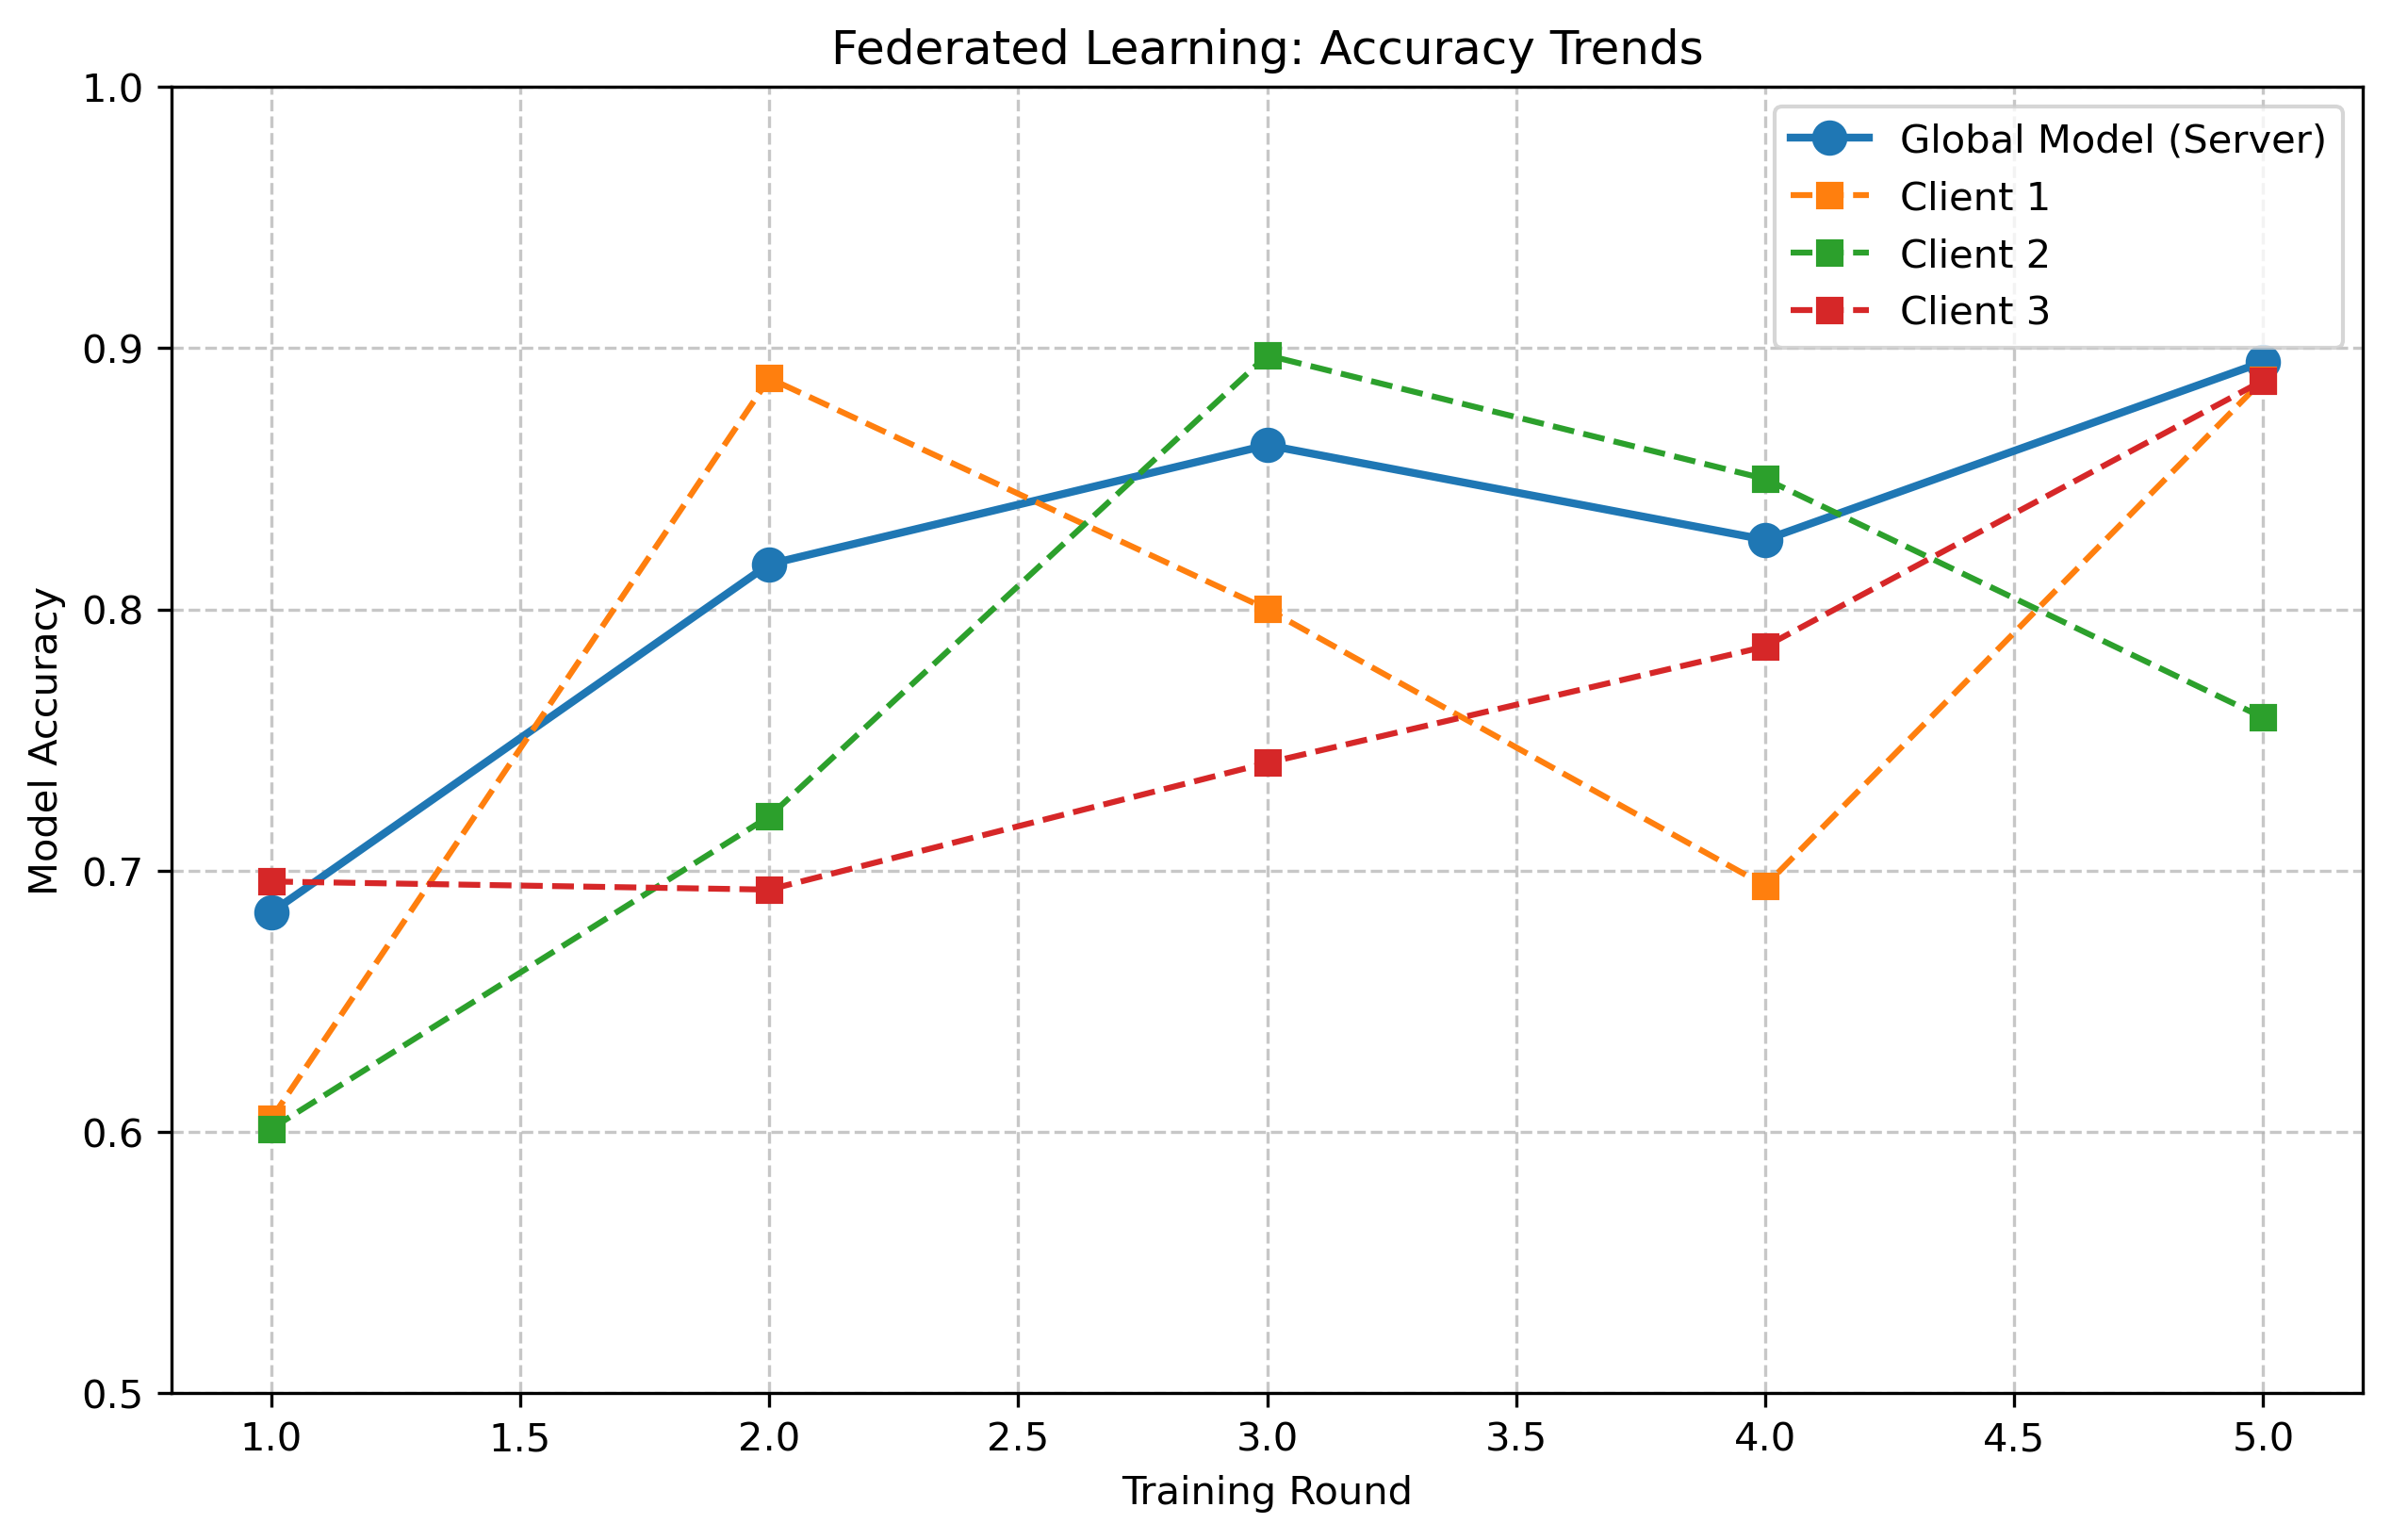

### 差分隐私对模型更新的影响

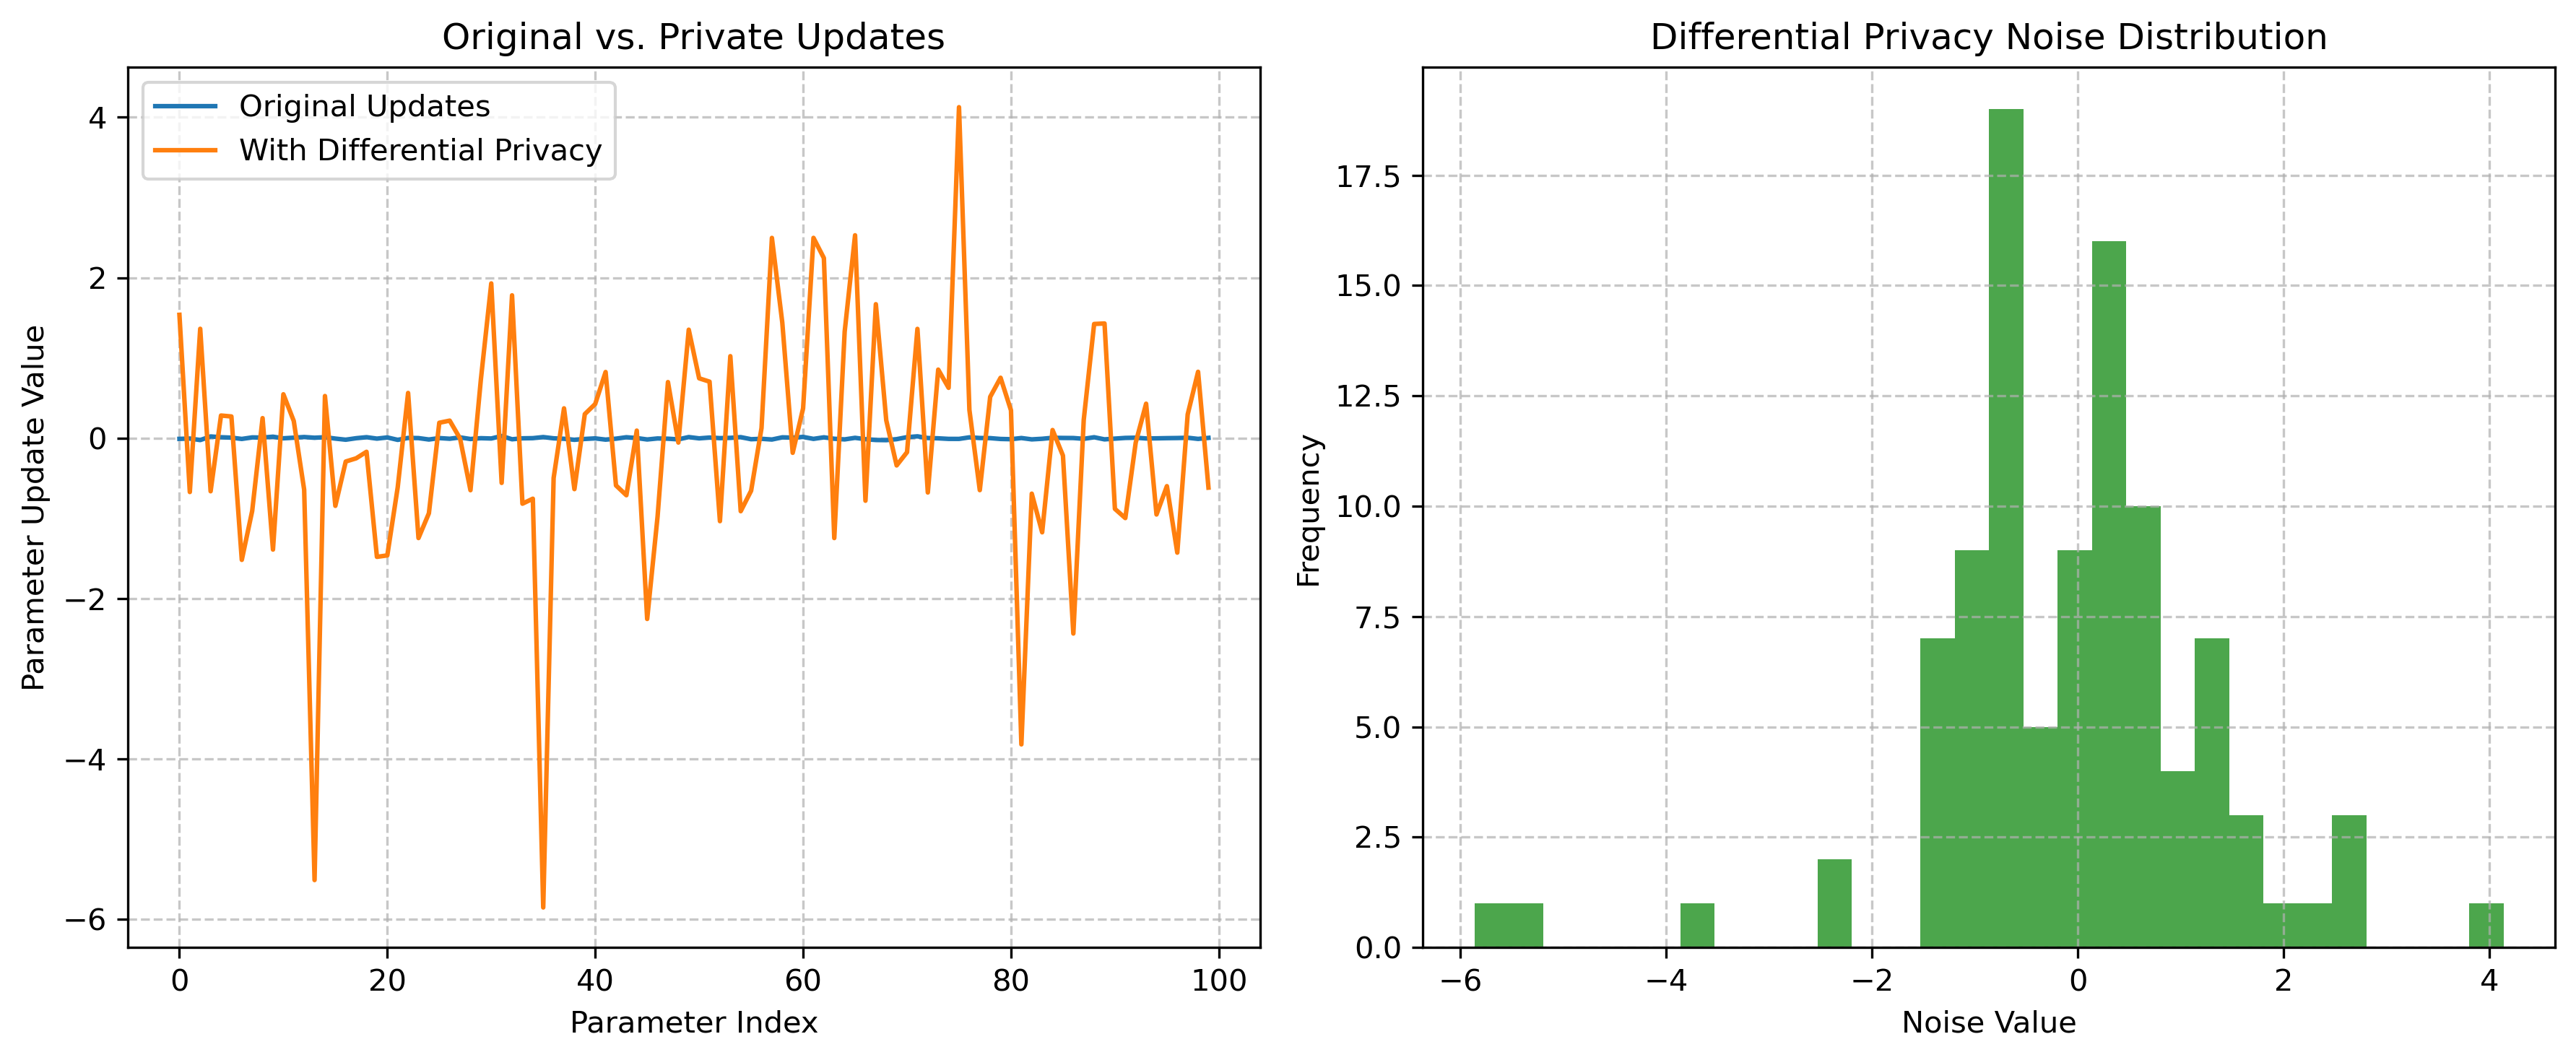

### 联邦学习过程中参数分布的演变

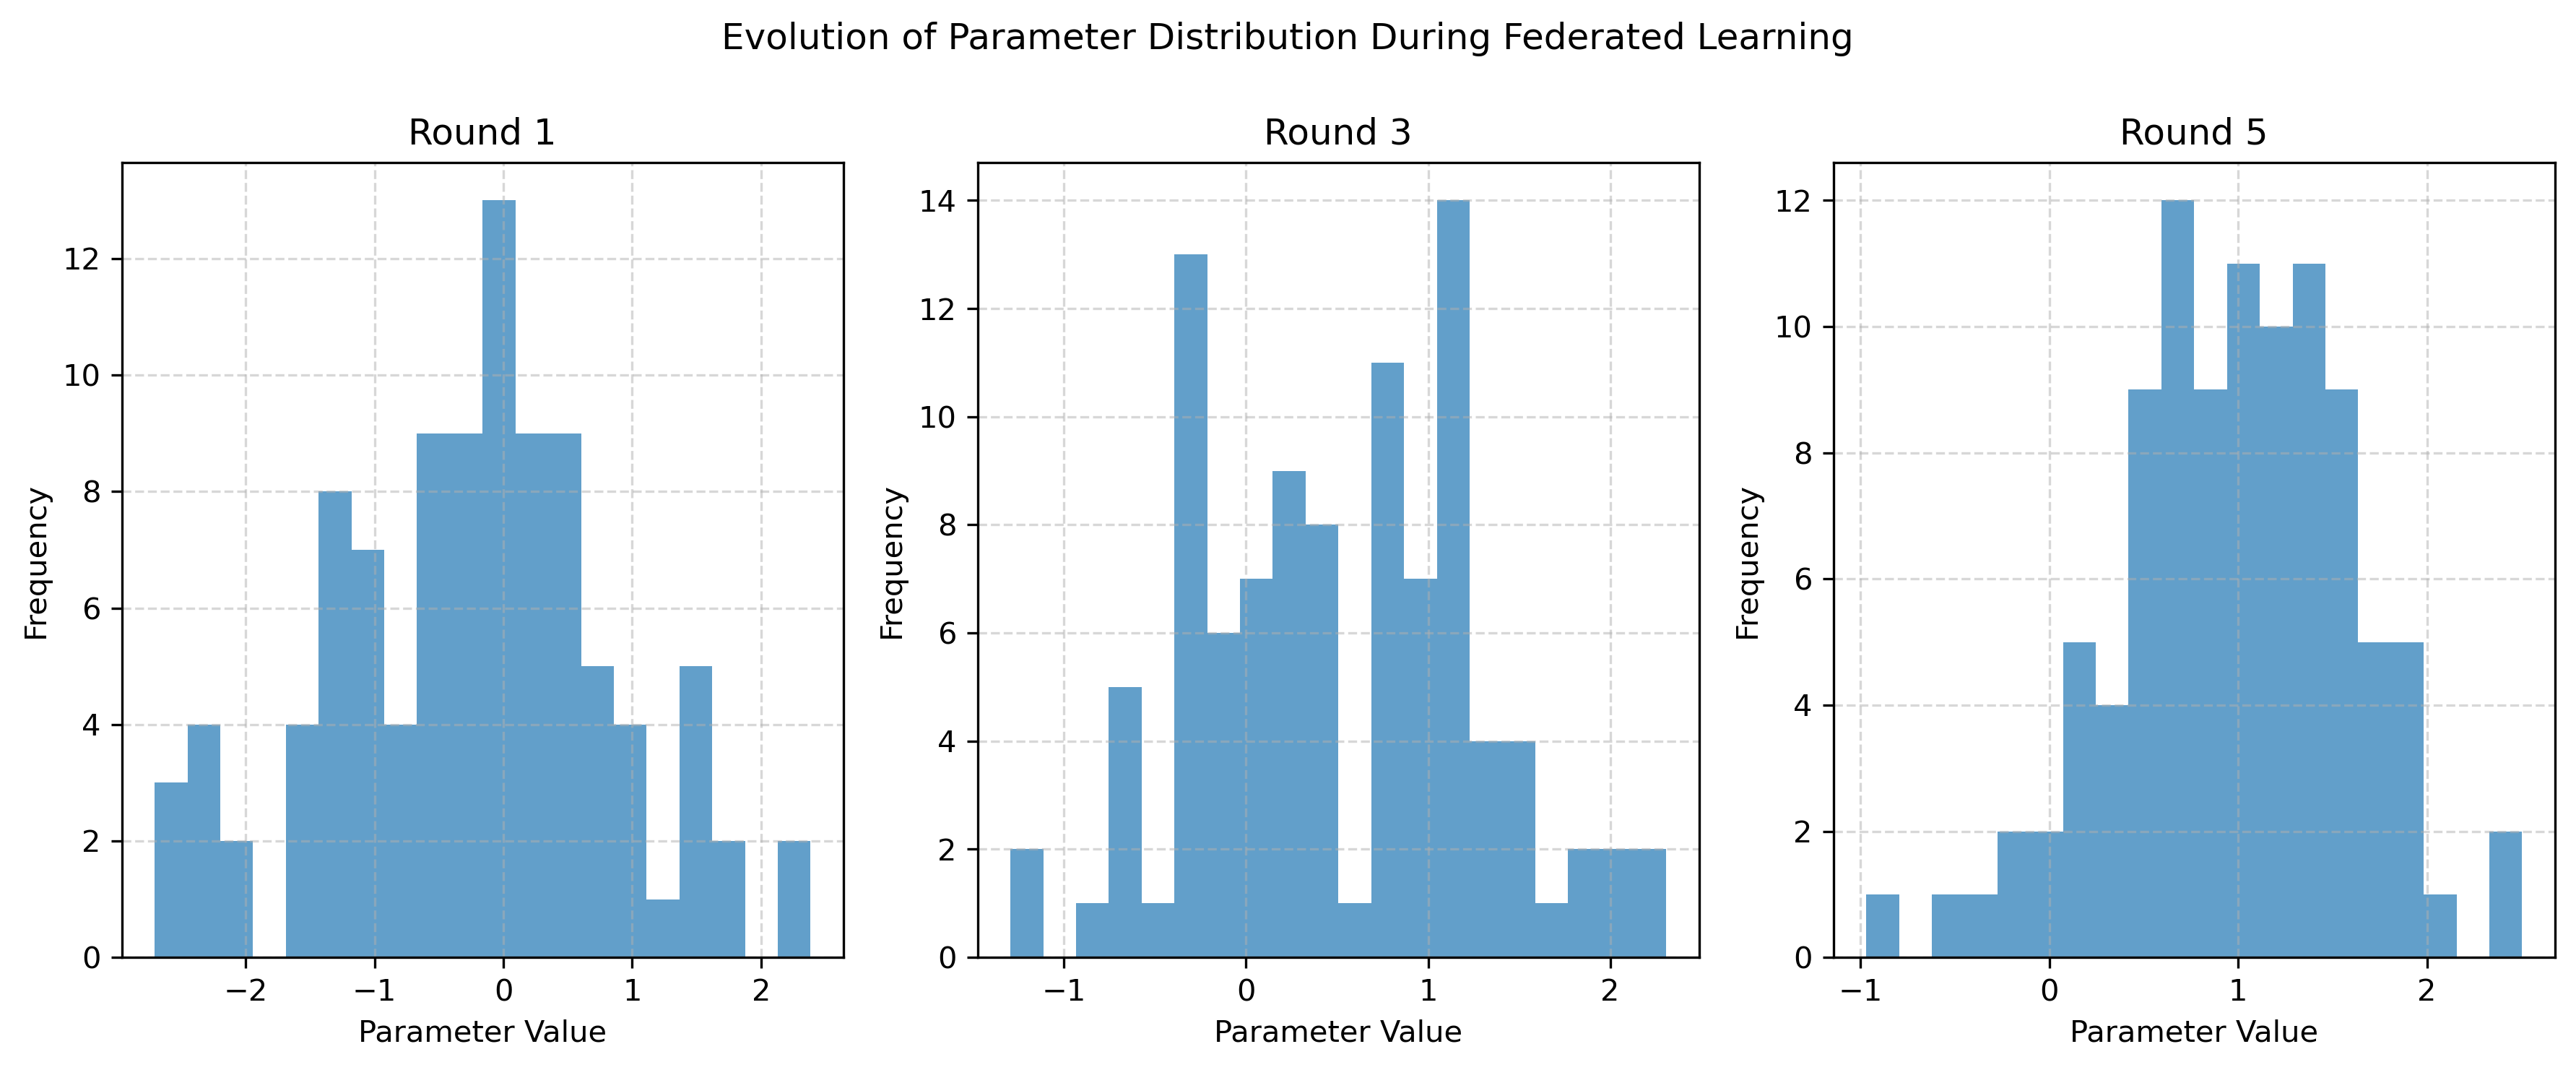

## 5. 差分隐私作为防御机制

### 不同隐私保护级别下对抗攻击防御效果对比

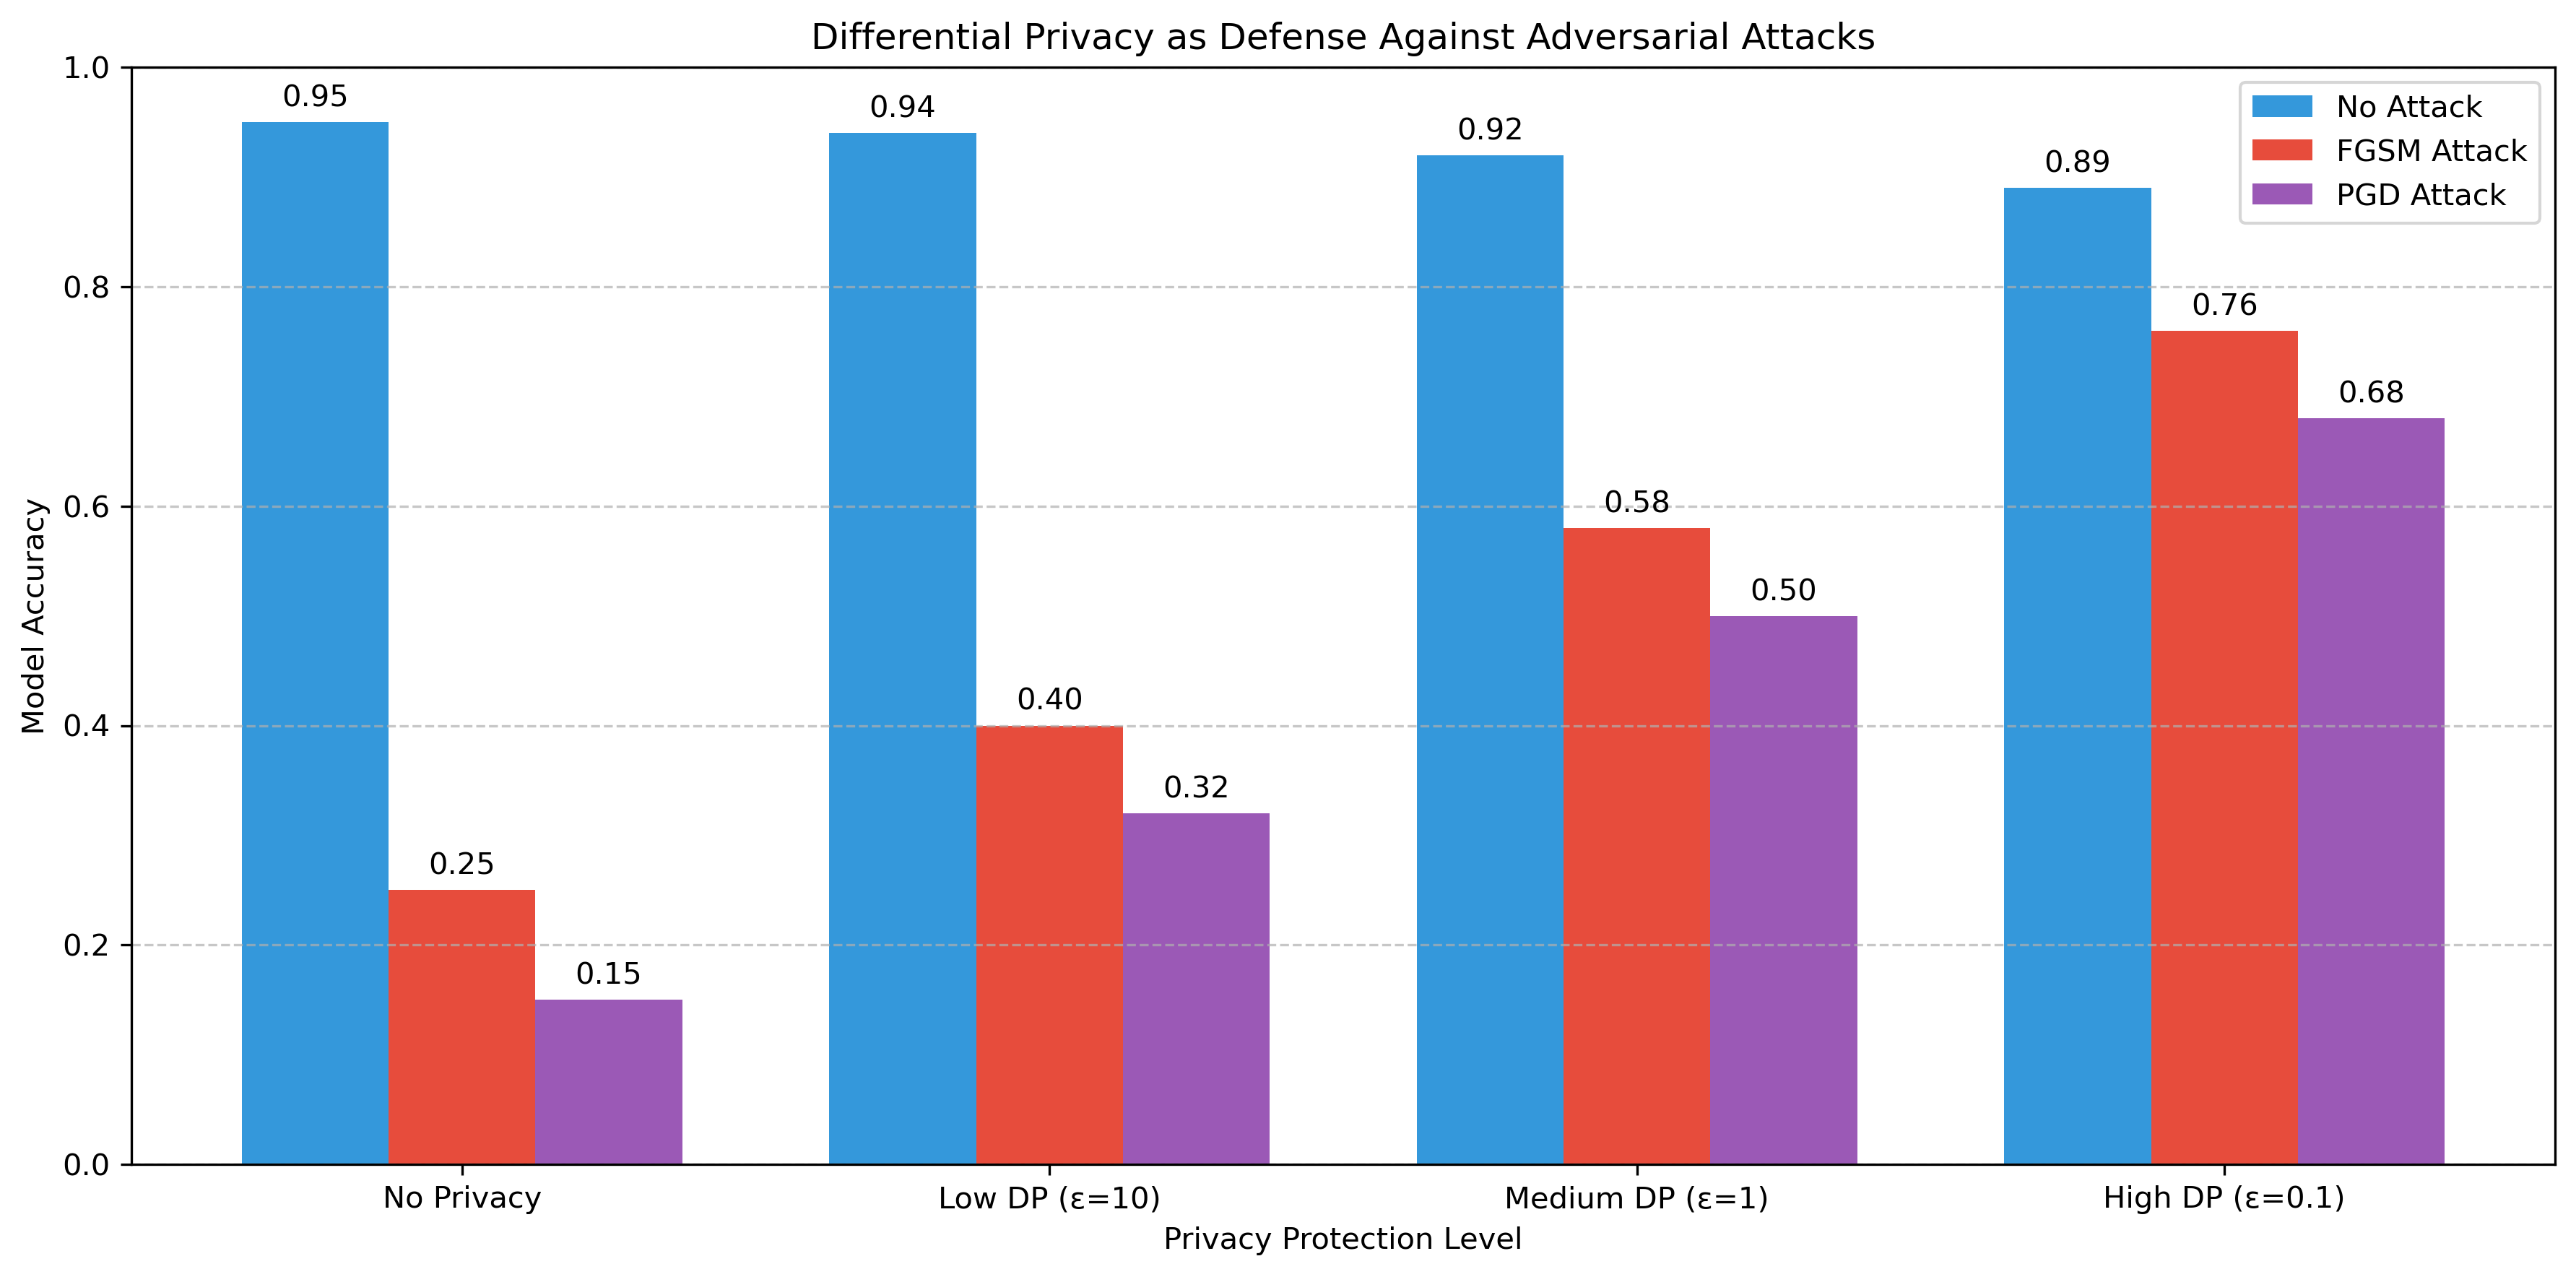

In [15]:
# 确保所有图片已保存，然后在summary中展示这些图片
from IPython.display import Image, display, Markdown
import os

# 检查图片目录是否存在，如果不存在则创建
os.makedirs('images', exist_ok=True)

# 定义一个函数来显示图片和描述
def show_image_with_description(image_path, description):
    display(Markdown(f"### {description}"))
    if os.path.exists(image_path):
        display(Image(image_path))
    else:
        display(Markdown(f"**图片未找到: {image_path}**"))

# 分组展示所有保存的可视化结果
display(Markdown("## 1. 对抗样本攻击可视化"))

# 展示FGSM攻击结果
show_image_with_description('images/fgsm_attack.png', '快速梯度符号法(FGSM)生成的对抗样本')

# 展示PGD攻击结果
show_image_with_description('images/pgd_attack.png', '投影梯度下降(PGD)生成的对抗样本')

# 展示PGD与原始图像的比较
show_image_with_description('images/pgd_comparison.png', 'PGD攻击前后图像对比')

display(Markdown("## 2. 学术界与工业界关注点分析"))

# 展示学术界与工业界关注点对比
show_image_with_description('images/focus_comparison.png', '学术界与工业界在对抗攻击研究中的关注焦点对比')

display(Markdown("## 3. 生成对抗网络(GAN)示例"))

# 展示GAN生成的样本
show_image_with_description('images/gan_sample.png', 'GAN生成的MNIST风格样本')

display(Markdown("## 4. 联邦学习与差分隐私"))

# 展示联邦学习模型性能趋势
show_image_with_description('images/federated_accuracy.png', '联邦学习过程中全局模型与客户端模型准确率变化')

# 展示差分隐私的影响
show_image_with_description('images/privacy_impact.png', '差分隐私对模型更新的影响')

# 展示参数分布随训练的变化
show_image_with_description('images/parameter_evolution.png', '联邦学习过程中参数分布的演变')

display(Markdown("## 5. 差分隐私作为防御机制"))

# 展示差分隐私对抗攻击防御效果
show_image_with_description('images/privacy_defense.png', '不同隐私保护级别下对抗攻击防御效果对比')

## 主要结论总结

### 1. 对抗攻击技术比较

| 攻击方法 | 特点 | 效果 | 适用场景 |
|---------|------|------|---------|
| **FGSM** | 单步梯度攻击，计算效率高 | 中等 | 快速攻击测试 |
| **PGD** | 迭代式攻击，计算成本高 | 强 | 评估模型鲁棒性下限 |
| **GAN** | 生成式，可产生更自然的样本 | 中等-强 | 逃避检测系统 |

### 2. 学术界与工业界关注点差异

- **学术界关注**：理论分析、防御算法效率、鲁棒性数学保证
- **工业界关注**：系统部署安全、法规合规、成本效益平衡、可解释性

### 3. 防御技术效果

- **对抗训练**：直接有效，但需要大量计算资源
- **联邦学习**：通过合作提高模型鲁棒性，同时保护数据隐私
- **差分隐私**：既是隐私保护机制，也能作为对抗防御手段

### 4. 差分隐私作为对抗防御的主要发现

- 随着隐私保护级别提高（ε值减小），模型对对抗攻击的鲁棒性增强
- 高强度隐私保护会略微降低常规准确率，但显著提高对抗鲁棒性
- 在隐私敏感且安全关键的应用中，差分隐私提供双重保护

### 5. 联邦学习中的模型表现

- 全局模型通常比单个客户端模型性能更好
- 即使在添加差分隐私噪声后，联邦平均机制仍能保持模型性能
- 参数分布随训练进行逐渐收敛，表明学习效果良好

## 未来研究方向

1. **自适应防御系统**：根据攻击类型和强度自动调整防御强度
2. **隐私-鲁棒性权衡**：探索差分隐私与模型鲁棒性间的理论关系
3. **跨域防御**：研究如何将一个领域的防御技术迁移到其他领域
4. **可解释安全**：增强对抗防御的可解释性，特别是在高风险应用中
5. **联邦学习安全**：进一步研究联邦学习中的攻击模式和防御策略

本笔记本展示了对抗学习中的基础概念，以及如何将差分隐私与联邦学习结合以增强模型安全性。这些技术在保护机器学习模型免受对抗攻击的同时，也保障了数据隐私，是未来安全AI系统的重要研究方向。